## [단계 ③] 학습, 테스트 데이터 선택
③-1. 학습, 테스트 데이터 선택
- 학습 데이터로는 길이가 적당한 정상적인 데이터로서 배터리 충전 데이터 중 하나인“1000_chg.csv”을 택한다.
- 이상 감지 테스트를 위하여 불량이 있는 테스트 데이터를 선택하여 MTadGAN 테스트를 수행한다. 본 가이드북에서 사용될 테스트 데이터 파일은 “Test07_NG_dchg.csv”인데 이 데이터는 센서와이어 불량으로 인해 전압 이상을 보인다.

## [단계 ④] AI모델 알고리즘 선택
④-1. AI모델 알고리즘 선택
- AI모델 알고리즘으로는 기존의 TadGAN 방법을 다변량 데이터로 확장한 MTadGAN 알고리즘을 주된 알고리즘으로 택하고 데이터의 차원을 축소하기 위하여 PCA 알고리즘을 초기 데이터 처리와 결합한다. MTadGAN 알고리즘을 사용하기 위해서는 Tensorflow 패키지를 설치하여야한다. 
- Tensorflow 및 분석에 필요한 패키지를 설치한다. 

In [1]:
# !pip install tensorflow==2.5.0
# !pip install graphviz==0.20.1
# !pip install pydot==1.4.2
# !pip install pydotplus==2.0.2
# !pip install pyts==0.12.0

- 데이터에 대한 학습과 테스트에 필요한 라이브러리를 호출한다. 대표적인 라이브러리로는 tensorflow 이외에 데이터를 편리하게 다루기 위한 라이브러리로서 pandas, numpy가 있고 그래픽 도구로서는 plotly, matplotlib 등이 있으며 다양한 기계학습 기타 통계 계산 도구로서 sklearn(scikit-learn)이 있다.
- pandas: 이차원의 데이터를 이름이 부여된 칼럼별로 테이블 형식으로 저장하고 편리하게 조작할 수 있도록 해준다.
- numpy: 다차원의 배열로 이루어진 수치 데이터를 편리하게 다룰 수 있도록 한다.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
# 라이브러리에서 필요한 모듈만 호출
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import math
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from random import randrange
import argparse
import collections
import tensorflow as tf
import logging
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense, Reshape, UpSampling1D, TimeDistributed
from tensorflow.keras.layers import Activation, Conv1D, LeakyReLU, Dropout, Add, Layer
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam
import pydot
import pydotplus
from pydotplus import graphviz
from scipy import stats
from scipy import integrate
from scipy.optimize import fmin
from pyts.metrics import dtw
from pandas.plotting import register_matplotlib_converters

## [단계 ⑤] AI모델 학습
⑤-1. AI모델 학습
- 먼저 MTadGAN을 이용하기 위해 필요한 파라미터를 설정한다. 중요한 파라미터로는 win_size, features_dim이 있는데 win_size 파라미터는 시계열 데이터에서 MTadGAN 모형으로 입력하는 데이터의 시간 윈도우의 크기를 나타낸다. 본 가이드북에서는 win_size=10으로 설정한다. 한편 features_dim 파라미터는 MTadGAN 모형에서 받아들이는 데이터 피쳐의 차원수를 말하는데 여기서는 features_dim=3으로 설정한다. 따라서 원래 데이터의 개수(차원수)는 약 200 쯤 되므로 PCA 알고리즘을 써서 이를 3 차원으로 축소한다. 이에 더하여 Dictionary 자료형 변수로 params를 정의하여 여러 가지 파라미터를 정의하는데 예를 들면 params[‘epochs’] 은 MTadGAN 모형 학습(training)에서의 반복 횟수를 나타내고 params[‘learning_rate’]는 MTadGAN 모형 학습에서의 학습률을 나타내며 params[‘latent_dim’]는 입력 데이터 벡터를 부호화(encoding) 할 때의 숨은(잠재) 공간의 차원을 표시한다.

In [3]:
# hyper parameters
win_size = 10                        # 시간의 윈도우 크기
features_dim = 3                     # PCA의 차원 수
feat_dim = features_dim
params = {}
params['plot_network'] = True        # 네트워크 구조를 시각화할지 여부를 나타내는 플래그.
params['epochs'] = 30                # 학습 시 전체 데이터셋을 몇 번 반복할지를 나타내는 에폭 수.
params['batch_size'] = 64            # 한 번의 학습에 사용되는 데이터 샘플의 수를 나타내는 배치 크기
params['n_critic'] = 5               # 비판자(critic) 네트워크의 업데이트 횟수
params['learning_rate'] = 0.000001    # 모델 학습 시 가중치를 업데이트하는 학습률
params['latent_dim'] = 20            # 잠재 공간(latent space)의 차원 수. 일반적으로 생성 모델(GAN)에서 사용
params['shape'] = [win_size, features_dim]                  # 입력 데이터의 기본 형태
params['encoder_input_shape'] = [win_size, features_dim]    # 인코더 네트워크의 입력 형태
params['encoder_reshape_shape'] = [20, 1]                   # 인코더 네트워크의 출력 형태를 변환할 때의 목표 형태
params['generator_input_shape'] = [20, 1]                   # 생성기 네트워크의 입력 형태
params['generator_reshape_shape'] = [win_size, 1]           # 생성기 네트워크의 출력 형태를 변환할 때의 목표 형태
params['critic_x_input_shape'] = [win_size, features_dim]   # 비판자 네트워크의 X 입력 형태.
params['critic_z_input_shape'] = [20, 1]                    # 비판자 네트워크의 Z 입력 형태
print("win_size = %d, features_dim = %d " % (win_size, features_dim))

win_size = 10, features_dim = 3 


- 학습 데이터 파일 “1000_chg.csv”을 지정하여 args.signal_file이라는 변수를 저장하며 기타 변수를 정한다. 이상값의 파일이 있으면 args.anomaly_file이라는 변수에 저장한다. args.mode = ‘train’은 학습 모드임을 나타낸다. 

In [4]:
arguments=collections.namedtuple('Args',
                            'signal_file timest_form anomaly_file mode aggregate_interval regate_interval')

args=arguments(signal_file = '../../data/preprocessed/train/1000_chg.csv',
    timest_form = 0,
    anomaly_file = '',
    mode = 'train',
    aggregate_interval = 1,
    regate_interval = 1)
print("argments")
print("----------------------")
print("args.timest_form :", args.timest_form)
print("args.signal_file :", args.signal_file)
print("args.anomaly_file :", args.anomaly_file)
print("args.mode :", args.mode)
print("args.aggregate_interval :", args.aggregate_interval)
print("----------------------\n")

argments
----------------------
args.timest_form : 0
args.signal_file : ../../data/preprocessed/train/1000_chg.csv
args.anomaly_file : 
args.mode : train
args.aggregate_interval : 1
----------------------



- 학습 데이터에 대한 차분 함수 diff_smooth_df()를 정의한다. 이 함수는 입력 데이터값을 일정한 시차(diffs_n>1)로 차이값을 구하거나 인접한 시점의 데이터 값들을 결합하여 데이터를 스무드하게 만드는 역할을 한다. 아래 코드에서는 diffs_n=0 등으로 지정하므로 차분함수가 원래 데이터를 그대로 두게 된다.

### 차분
- 시계열 데이터의 분석 및 예측에서 중요한 기법 중 하나로, 데이터의 트렌드(추세)나 계절성을 제거하여 시계열 데이터를 안정화(stationary)시키는 데 사용
- 차분은 시계열 데이터의 연속적인 데이터 포인트 간의 차이를 계산하는 것
1. 1차 차분
    - 연속적인 데이터 포인트 간의 차이를 계산
    - 수식: $ \Delta y_t = y_t - y_{t-1} $
    - 주로 데이터의 단순 추세를 제거하는 데 사용
2. 2차 차분
    - 1차 차분을 한 번 더 차분
    - 수식 : $ \Delta^2 y_t = \Delta y_t - \Delta y_{t-1} = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} + y_{t-2} $
    - 더 복잡한 추세나 패턴을 제거하는 데 사용
3. 계절 차분
    - 특정 계절 주기를 고려하여 차분
    - 수식 : $ \Delta_s y_t = y_t - y_{t-s} $
    - 주로 계절성을 제거하는 데 사용
4. d차 차분
    - 수식 : $ \Delta^d y_t = \sum_{k=0}^{d} (-1)^k \binom{d}{k} y_{t-k} $
#### 차분의 목적
- 시계열 데이터의 비정상성을 제거해 데이터를 정상성을 띄게 만드는 것. 정상성을 띄는 시계열 데이터는 평균, 분산이 시간에 따라 변하지 않으며, 자기상관성이 일정한 특성을 가짐. 

### 평활화
- 주로 이동 평균을 계산하는 방식으로 이루어짐. 평활화횟수는 이동 평균을 계산할 때 창의 크기를 나타냄. 예를 들어, 평활화 횟수가 3이면 각 데이터 포인트는 자신과 그 이전 2개 포인트를 포함한 3개의 데이터 포인트의 평균으로 대체.

#### 효과
- 노이즈 감소 : 평활화는 데이터의 단기적인 변동을 줄이고, 더 장기적인 추세를 강조
- 추세 시각화 : 데이터의 주요 추세를 더 명확하게 볼 수 있게 함

In [5]:
diffs_n = 0     # 차분을 적용할 횟수
lags_n = 0      # 특징 벡터에 포함될 시차의 개수
smooth_n = 0    # 특징 벡터에 포함될 최신 값들을 평활화할 횟수
print("diffs_n: ", diffs_n)

def diff_smooth_df(df, lags_n, diffs_n, smooth_n, diffs_abs=False, abs_features=False):
    """입력 데이터프레임에 대해 차분, 평활화, 시차를 적용하여 전처리"""
    # 차분 차수가 1 이상인 경우 차분 적용
    if diffs_n >= 1:
        df = df.diff(diffs_n).dropna()
    # 절댓값 차분을 적용
    if diffs_abs == True:
        df = abs(df)
    # 이동 평균을 적용하여 데이터를 약간 평활화함
    if smooth_n >= 2:
        df = df.rolling(smooth_n).mean().dropna()
    # 라그 값이 1 이상인 경우
    if lags_n >= 1:
        # 각 차원에 대해 차분 및 평활화된 값에 대해 lags_n 시차의 새로운 열을 추가함
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n + 1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # 특징 벡터를 볼 때 명확성을 위해 열을 정렬함
    df = df.reindex(sorted(df.columns), axis=1)
    # 모든 특징을 절대값으로 변환함 (만약 abs_features가 True인 경우)
    if abs_features == True:
        df = abs(df)

    return df

print("import diff_smooth_df() : Done ! ")

diffs_n:  0
import diff_smooth_df() : Done ! 


- PCA 알고리즘을 적용하여 학습 데이터의 차원을 3차원으로 축소한다.

In [6]:
######## 데이터 PCA 진행 ################################
signal_path = args.signal_file
df_train_0= pd.read_csv(signal_path)
data_0 = df_train_0                 # 데이터 복사
# preprocess or 'featurize' the training data
data_1 = diff_smooth_df(data_0, lags_n, diffs_n, smooth_n)
pca = PCA(n_components=features_dim)        # 입력 차원의 PCA 생성
data = pca.fit_transform(data_1)            # 입력 데이터 PCA로 차원 축소 수행
df_1 = []                                   # 데이터프레임 역할을 할 배열
for i in range(len(data)):
    row = [i+1]                             # 각 행의 인덱스 설정
    for jj in range(features_dim):          # 차원 수 만큼 주성분 입력
        row.append(data[i][jj])
    df_1.append(row)                        # 데이터프레임에 추가
df = pd.DataFrame(df_1)                     # 반복 수행 후 데이터 프레임화
columns_new = ['date']                      # 데이터프레임의 인덱스열
for i in range(1, features_dim+1):          # pca
    pca_i = f'pca_{str(i)}'                 # 제i 주성분
    columns_new.append(pca_i)
df.columns = columns_new
print("주성분 차원 축소 후 df.shape = ", df.shape)
print("----------------------")
print(df.head(5))
print("----------------------")
print("\n")

주성분 차원 축소 후 df.shape =  (6009, 4)
----------------------
   date      pca_1     pca_2     pca_3
0     1  18.634349  0.564999  0.261410
1     2  18.635771  0.571294  0.263656
2     3  18.635892  0.570799  0.263567
3     4  18.634366  0.564929  0.261397
4     5  18.666694  0.565826  0.255594
----------------------




- 입력 학습 데이터의 시간-집합화(time-aggregate) 과정을 수행하는 함수 time_segments_aggregate()를 정의한다. 이는 위에서 정의한 변수 args.aggregate_interval의 값이 1보다 클 때 그 구간 안의 데이터를 평균하거나하여 데이터를 조정하는 함수이다. 여기에서는 args.aggregate_interval=1로 설정한다.

In [7]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """주어진 시간 간격에 대해 값을 집계함.
    Args:
    X (ndarray 또는 pandas.DataFrame): N차원 시퀀스 값.
    interval (int): 집계를 계산할 시간 간격을 나타내는 정수.
    time_column (int): X에서 시간 값을 포함하는 열.
    method (str 또는 list):
    선택적. 집계 방법을 설명하는 문자열 또는 여러 집계 방법을 설명하는 문자열 목록. 지정하지 않으면 'mean'이 사용.
    Returns:
    ndarray, ndarray:
    * 집계된 값의 시퀀스, 각 집계 방법에 대해 하나의 열.
    * 집계된 각 세그먼트의 첫 번째 인덱스 값의 시퀀스.
    """
    if isinstance(X, np.ndarray):   # 만약 X가 배열이라면 데이터프레임으로 변환
        X = pd.DataFrame(X)
    X = X.sort_values(time_column).set_index(time_column)   # 시간 열을 기준으로 정렬하고, 시간 열을 인덱스로 설정
    if isinstance(method, str):     # 만약 `method`가 문자열이면, 리스트로 변환
        method = [method]
    start_ts = X.index.values[0]    # 데이터의 시작 시간
    max_ts = X.index.values[-1]     # 데이터의 마지막 시간
    values = list()                 # 집계된 값을 저장할 리스트
    index = list()                  # 집계된 각 세그먼트의 시작 시간을 저장할 리스트
    while start_ts <= max_ts:       # 시작부터 마지막까지
        end_ts = start_ts + interval    # 시간 간격을 계산
        subset = X.loc[start_ts:end_ts-1]   # 해당 간격을 선택
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method]
        values.append(np.concatenate(aggregated))   # 집계 결과 추가
        index.append(start_ts)                      # 시작 시간을 리스트에 추가
        start_ts = end_ts                           # 시작 시간 갱신(현재 간격 종료 시간으로)
    return np.asarray(values), np.asarray(index)    # 집계 결과를 ndarray로 반환


- time_segments_aggregate() 함수를 작용하고 이들 값을 [-1,+1] 사이의 값으로 정규화한다.

In [8]:
# 시간 집합화 수행
X, index = time_segments_aggregate(df, interval=args.aggregate_interval, time_column='date')
print("signal data (after time_segments_aggregate) = ", X.shape)
print("--------------------------------------------")
print(X[:5])
print("--------------------------------------------")
print("\n")

# 최대최소 정규화 적용
X = SimpleImputer().fit_transform(X)
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
print("X (after MinMaxScaler) = ", X.shape)
print("--------------------------------------------")
print(X[:5])
print("--------------------------------------------")
print("\n")
X_norm = X 

signal data (after time_segments_aggregate) =  (6009, 3)
--------------------------------------------
[[18.6343489   0.56499908  0.26141038]
 [18.63577092  0.57129376  0.26365645]
 [18.63589171  0.57079932  0.26356652]
 [18.63436617  0.56492876  0.26139721]
 [18.66669403  0.56582562  0.25559404]]
--------------------------------------------


X (after MinMaxScaler) =  (6009, 3)
--------------------------------------------
[[0.99721634 0.48867576 0.26892606]
 [0.99732535 0.49487412 0.27233804]
 [0.99733461 0.49438724 0.27220142]
 [0.99721766 0.48860651 0.26890604]
 [0.99969584 0.48948965 0.2600905 ]]
--------------------------------------------




- 학습 데이터를 AI 알고리즘이 요구하는 입력 윈도우 길이(win_size)에 맞게 묶는 함수인 rolling_window_sequences() 함수를 정의한다. 즉, 만일 win_size=10이면 연속한 10개의 데이터 값을 벡터로 묶어서 입력값으로 사용한다.

In [9]:
def rolling_window_sequences(X, index, window_size, target_size, step_size,
    target_column, drop=None, drop_windows=False):
    """시계열 데이터에서 롤링 윈도우 시퀀스를 생성함.
    이 함수는 입력 시퀀스를 롤링 윈도우로 순회하며 입력 시퀀스 배열과 목표 시퀀스 배열을 생성함.
    선택적으로 시퀀스에서 특정 값을 삭제할 수 있음.
    
    Args:
    X (ndarray): 순회할 N차원 시퀀스.
    index (ndarray): X의 인덱스 값을 포함하는 배열.
    window_size (int): 입력 시퀀스의 길이.
    target_size (int): 목표 시퀀스의 길이.
    step_size (int):  # 윈도우를 각 라운드마다 몇 단계씩 앞으로 이동할지 나타내는 값.
    target_column (int): X의 어느 열이 목표인지를 나타내는 값.
    drop (ndarray 또는 None 또는 str 또는 float 또는 bool):  # 선택적. X의 어떤 값이 유효하지 않은지 나타내는 부울 값 배열 또는 삭제할 값을 나타내는 값. 지정하지 않으면 `None`이 사용됨.
    drop_windows (bool): 선택적. 삭제 기능을 활성화할지 여부를 나타냄. 지정하지 않으면 `False`가 사용됨.
    
    Returns:
    ndarray, ndarray, ndarray, ndarray:
    * 입력 시퀀스.
    * 목표 시퀀스.
    * 각 입력 시퀀스의 첫 번째 인덱스 값.
    * 각 목표 시퀀스의 첫 번째 인덱스 값.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]
    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('배열 `drop`과 `X`는 같은 길이여야 합니다.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop
    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size
        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue
        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size
    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)


- 학습 데이터에 rolling_window_sequences() 함수를 적용하여 MTadGAN 알고리즘에 입력할 수 있도록 만든다. 즉, MTadGAN에서는 시계열 데이터를 모형으로 입력할 때에 특정한 시점에 대하여 일정한 윈도우 길이(win_size)만큼 묶어서 입력하게 된다. rolling_window_sequences() 함수는 입력 윈도우 길이(win_size)에 맞게 모든 시점에 대하여 묶는 함수이다. 만일 win_size=10이면 모든 시점에 대하여 각각 근처의 연속한 10개의 데이터 값을 벡터로 묶어서 입력값으로 사용할 수 있게 한다.

In [10]:
# 윈도우 길이에 맞게 묵음
X, y, X_index, y_index=rolling_window_sequences(X, index, window_size=win_size, target_size=1, step_size=1, target_column=0)
print("X shape (after rolling_window_seq): {}".format(X.shape))
print("X : ")
print(X[:3, :5])
print("X index shape: {}".format(X_index.shape))
print("y shape: {}".format(y.shape))
print("y : ")
print(y[:5])
print("y index shape: {}".format(y_index.shape))
print("\n")

X shape (after rolling_window_seq): (5999, 10, 3)
X : 
[[[0.99721634 0.48867576 0.26892606]
  [0.99732535 0.49487412 0.27233804]
  [0.99733461 0.49438724 0.27220142]
  [0.99721766 0.48860651 0.26890604]
  [0.99969584 0.48948965 0.2600905 ]]

 [[0.99732535 0.49487412 0.27233804]
  [0.99733461 0.49438724 0.27220142]
  [0.99721766 0.48860651 0.26890604]
  [0.99969584 0.48948965 0.2600905 ]
  [0.99729103 0.49165725 0.27192521]]

 [[0.99733461 0.49438724 0.27220142]
  [0.99721766 0.48860651 0.26890604]
  [0.99969584 0.48948965 0.2600905 ]
  [0.99729103 0.49165725 0.27192521]
  [0.99741076 0.49573991 0.26903184]]]
X index shape: (5999,)
y shape: (5999, 1)
y : 
[[0.99860594]
 [0.99594234]
 [0.99452801]
 [1.        ]
 [0.9959476 ]]
y index shape: (5999,)




- GPU가 있는지 체크한다. GPU가 있을 시 GPU 정보가 나오며, GPU가 없을 시 아래와 같은 결과가 나오게 된다.

In [11]:
# GPU 환경 존재 여부 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print (gpus)

[]


- MTadGAN에 필요한 함수 중 하나로서 RandomWeightedAverage() 클래스를 정의하는데 이는 입력 데이터와 예측된 입력 데이터를 정해진 비율로 선형 결합하는 역할을 한다.

In [12]:
class RandomWeightedAverage(Layer):
    def __init__(self, batch_size):
        """레이어 초기화
        Args:
        batch_size: 배치 크기 (예: 64)
        """
        super(RandomWeightedAverage, self).__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        """랜덤 가중 평균 계산
        Args:
        inputs[0] x: 원래 입력
        inputs[1] x_: 예측된 입력
        """
        alpha = tf.random.uniform((self.batch_size, 1, 1))  # 배치 크기에 따라 랜덤 가중치 생성
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])  # 원래 입력과 예측된 입력의 랜덤 가중 평균을 반환

print("RandomWeightedAverage() Class defined, Done! ") 

RandomWeightedAverage() Class defined, Done! 


- MTadGAN의 encoder 레이어를 생성하는 함수를 정의한다. 이는 입력 데이터를 숨은 공간으로 임베딩하는 기능을 한다.

In [13]:
def build_encoder_layer(input_shape, encoder_reshape_shape):
    """인코더 레이어를 생성
    인자들:
    input_shape: [10, 1]
    encoder_reshape_shape: [20, 1]
    
    Returns:
    인코더 모델
    """
    x = Input(shape=input_shape)
    model = tf.keras.models.Sequential([
        Bidirectional(LSTM(units=win_size, return_sequences=True)), 
        Flatten(),
        Dense(20), # 20 = self.critic_z_input_shape[0]
        Reshape(target_shape=encoder_reshape_shape)]) # (20, 1)
    return Model(x, model(x))

print("인코더 레이어 생성 함수 정의 완료")

인코더 레이어 생성 함수 정의 완료


- Bidirectional : LSTM 레이어를 감싸서 순방향과 역방향 모두 입력 시퀀스를 처리하도록 함
    - units : LSTM 레이어의 유닛(뉴런) 수. win_size 만큼의 unit을 가짐
    - return_sequences = True : 각 타임스텝마다 생성된 출력 벡터 반환
    - units 인자를 증가시키는 경우 더 복잡한 학습이 가능하지만 과적합의 위험이 커짐
- Flatten : 다차원 텐서 배열을 차원으로 변환시키는 역할
- Dense : 완전 연결층. 모든 입력 뉴런이 모든 출력 뉴런과 연결되도록 함.
    - units : 뉴런의 수. 여기서 
    - activation : 활성화 함수. 미지정 시 linear(선형)
- Reshape : 입력 데이터의 차원을 변경하는 역할
- 모델의 층
```
Input Layer: (10, 1)
    |
Bidirectional LSTM Layer (units=win_size): (10, 2 * win_size)
    |
Flatten Layer: (10 * 2 * win_size)
    |
Dense Layer (units=20): (20)
    |
Reshape Layer (target_shape=(20, 1)): (20, 1) : 출력층의 역할
```

- MTadGAN의 generator 레이어를 생성하는 함수를 정의한다. 이는 숨은 공간으로부터 가상의 데이터를 생성하는 역할을 한다.

In [14]:
def build_generator_layer(input_shape, generator_reshape_shape):
    # input_shape = (20, 1) / generator_reshape_shape = (50, 1)
    x = Input(shape=input_shape)
    model = tf.keras.models.Sequential([
        Flatten(),  # 입력을 1차원으로 평탄화
        Dense(win_size),  # 원래 50이었던 win_size만큼의 유닛을 가진 Dense 레이어
        Reshape(target_shape=generator_reshape_shape),  # (50, 1) 형태로 변환
        # 양방향 LSTM 레이어, 64 유닛, 시퀀스를 반환하며, 순방향과 역방향 출력을 연결
        Bidirectional(LSTM(units=64, return_sequences=True), merge_mode='concat'),  
        Dropout(rate=0.2),  # 드롭아웃 20%
        #UpSampling1D(size=2),
        UpSampling1D(size=1),  # 시퀀스 데이터를 1배 업샘플링
        # 양방향 LSTM 레이어, 64 유닛, 시퀀스를 반환하며, 순방향과 역방향 출력을 연결
        Bidirectional(LSTM(units=64, return_sequences=True), merge_mode='concat'),  
        Dropout(rate=0.2),  # 드롭아웃 20%
        # 시퀀스 데이터의 각 타임 스텝에 대해 Dense 레이어를 적용. features_dim은 출력 특성의 수(PCA 차원 수)
        TimeDistributed(Dense(features_dim)),  
        Activation(activation='tanh')])  # tanh 활성화 함수를 사용하여 출력. 최종 출력 형태는 (None, 10, 1)
    print(model.get_config())
    return Model(x, model(x))
print("생성기 레이어 생성 함수 정의 완료!")

생성기 레이어 생성 함수 정의 완료!


- Bidrectional
    - merge_mode : 두 방향의 출력을 어떻게 결합할지
        - sum : 순방향과 역방향 출력을 더함
        - mul : 곱함
        - ave : 평균
        - concat : 연결하여 결합. 차원 수 2배
- upSampling1D : 업샘플링하여 시퀀스의 길이를 늘림
    - size = 1 : 시퀀스의 길이는 변하지 않음
    - size = 2 : 시퀀스의 타임 스텝이 2배가 됨
- Dropout : 일부 뉴런을 학습에서 제외하여 과적합을 방지하는 역할
    - rate : 드롭아웃 비율
- TimeDistributed : 입력 시퀀스의 각 타임 스텝에 대해 지정된 레이어를 독립적으로 적용
- Activation : tanh
    - 신경망의 출력을 특정 범위로 변환하는 데 사용. 
    - 신경망의 각 뉴런이 출력하는 값을 변환해 비선형성을 도입. 모델이 더 복잡한 패턴을 학습하도록 함
    - tanh 활성화 함수는 출력을 -1과 1 사이로 조절(주성분 분석을 위한 출력 결과)

- MTadGAN의 판별자 critic_x 레이어를 만드는 함수를 정의한다. 여기에서 critic_x는 실제의 학습 데이터와 숨은 공간에서 생성된 가상의 데이터를 구별해내는 판별자 네트워크를 말한다. 여기에서 critic_x는 실제의 학습 데이터와 숨은 공간에서 생성된 가상의 데이터를 구별해내는 판별자 네트워크를 말한다. 즉, 실제의 데이터 X 에서 나오는 시계열 시퀀스들과 생성자 G(z) 에서 생성된 가짜의 시계열 시퀀스들을 분별해내는 함수이다.

In [15]:
# win_size에 따라 커널 사이즈 조정
if win_size >= 30:
    k_size = 5
else:
    k_size = 2

def build_critic_x_layer(input_shape):
    """critic_x 레이어 생성
    Args:
    critic_x_input_shape: [10, 1]
    Returns:
    critic_x 모델
    """
    x = Input(shape=input_shape)
    model = tf.keras.models.Sequential([
        Conv1D(filters=64, kernel_size=k_size),  # 64개 필터, 
        LeakyReLU(alpha=0.2),  # LeakyReLU 활성화 함수, 
        Dropout(rate=0.25),  # 드롭아웃 25%
        Conv1D(filters=64, kernel_size=k_size),  
        LeakyReLU(alpha=0.2),  
        Dropout(rate=0.25),  
        Conv1D(filters=64, kernel_size=k_size),  
        LeakyReLU(alpha=0.2),  
        Dropout(rate=0.25),  
        Conv1D(filters=64, kernel_size=k_size),  
        LeakyReLU(alpha=0.2),  
        Dropout(rate=0.25),  
        Flatten(),  # 1차원으로 평탄화
        Dense(units=1)  # 1개의 유닛을 가진 Dense 레이어
    ])
    return Model(x, model(x))

print("critic_x 레이어 생성 함수 정의 완료")

critic_x 레이어 생성 함수 정의 완료


- Conv1D : 
    - kernel_size : 합성곱 연산 수행 시의 사용하는 커널의 크기
    - 커널 사이즈 2 : 작은 구간에서 특징 추출. 세부적인 패턴 인식. 인접한 두 타임 스텝에서 특징 추출
    - 커널 사이즈 5 : 더 넓은 구간서 추출. 큰 패턴 트렌드 인식. 인접 다섯 타임 스텝에서 특징 추출
    - 커널이 클수록 많은 계산 필요로 함
- LeakyReLU : 활성화함수 중 하나
    - 음수 입력에 대해서도 작은 기울기를 갖게 하여 죽은 뉴런 문제를 해결
    - alpha : 음수입력에 대한 기울기. 보통 0.01 혹은 0.2
    - 너무 큰 alpha 값은 음수 입력에 대한 기울기를 크게 하여 모델의 성능 저하
    - 너무 작은 alpha는 ReLU와 다를 게 없음
    - ReLU는 alpha=0인 경우
- ReLU : ReLU 계열의 활성화함수의 기반이 되는 활성화함수
    - 간단하고 계산 비용이 적으며, 기울기 소실 문제를 해결하는 활성화함수
    - 학습 속도와 예측 속도가 빠르며, 깊은 신경망에서도 효과적
    - 죽은 뉴런 문제와 출력의 비대칭성

- MTadGAN의 판별자 critic_z 레이어를 만드는 함수를 정의한다. critic_z는 실제의 학습 데이터 샘플로부터 encoding 된 벡터와 그냥 숨은 공간에서 샘플된 벡터 사이를 구별해내는 역할을 한다. 구별해내는 판별자 네트워크를 말한다. 즉, 그림 19에서 보듯이 무작위로 택한 잠재공간 내의 표본 z 와 학습 데이터 샘플로부터 생성자 E(x) 를 써서 인코딩(encoding)된 표본을 분별하는 함수(네트워크)이다. 즉 그림 19에서 보듯이 critic_z는 잠재공간(embedding space) 내에서의 판별자이고 critic_x는 이와 반대로 실제 데이터 공간에서의 판별자가 된다.

In [16]:
def build_critic_z_layer(input_shape):
    """critic_z 레이어 생성
    Args:
    critic_z_input_shape: [20, 1]
    Returns:
    critic_z 모델
    """
    x = Input(shape=input_shape)
    model = tf.keras.models.Sequential([
        Flatten(),  # 입력을 1차원으로 평탄화
        Dense(units=100),  # 100개의 유닛을 가진 Dense 레이어
        LeakyReLU(alpha=0.2),  # LeakyReLU 활성화 함수, 알파=0.2
        Dropout(rate=0.2),  # 드롭아웃 20%
        Dense(units=100),  
        LeakyReLU(alpha=0.2), 
        Dropout(rate=0.2),  
        Dense(units=1)  # 1개의 유닛을 가진 Dense 레이어
    ])
    return Model(x, model(x))

print("critic_z 레이어 생성 함수 정의 완료")

critic_z 레이어 생성 함수 정의 완료


- MTadGAN의 Wasserstein 로스 함수를 정의한다. Wasserstein 로스 함수는 두 확률분포 사이의 거리를 주는 함수로서 판별자 네트워크의 학습에 쓰이는 로스함수이다.

In [17]:
def wasserstein_loss(y_true, y_pred):
    """Wasserstein 손실 계산
    Args:
    y_true: 실제 값
    y_pred: 예측 값
    Returns:
    loss: Wasserstein 손실
    """
    return K.mean(y_true * y_pred)
print("Wasserstein 손실 함수 정의 완료")

Wasserstein 손실 함수 정의 완료


- MTadGAN에서 필요로 하는 checkpoints 디렉터리, 기타 앞에서 정의한 네트워크 파라미터 값을 복사한다. checkpoints 디렉터리는 학습된 MTadGAN 모형을 저장하는 데에 쓰인다.

In [18]:
ckpt_dir = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(ckpt_dir, exist_ok=True)
network_dir = os.path.join(os.getcwd(), 'networks')
os.makedirs(network_dir, exist_ok=True)
# 네트워크 플랏
plot_network = params['plot_network']
# 학습 파라미터
batch_size = params['batch_size']
n_critics = params['n_critic']
epochs = params['epochs']
# 층 파라미터
shape = params['shape']
window_size = shape[0]
feat_dim = shape[1]
latent_dim = params['latent_dim']
encoder_input_shape = params['encoder_input_shape']
generator_input_shape = params['generator_input_shape']
critic_x_input_shape = params['critic_x_input_shape']
critic_z_input_shape = params['critic_z_input_shape']
encoder_reshape_shape = params['encoder_reshape_shape']
generator_reshape_shape = params['generator_reshape_shape']
print('MTadGAN 초기화')
print("latent_dim= ", latent_dim)
print("shape= ", shape)
print("encoder_input_shape= ", encoder_input_shape)
print("generator_input_shape= ", generator_input_shape)
print("critic_x_input_shape= ", critic_x_input_shape)
print("critic_z_input_shape= ", critic_z_input_shape)
print("encoder_reshape_shape= ", encoder_reshape_shape)
print("generator_reshape_shape= ", generator_reshape_shape)

MTadGAN 초기화
latent_dim=  20
shape=  [10, 3]
encoder_input_shape=  [10, 3]
generator_input_shape=  [20, 1]
critic_x_input_shape=  [10, 3]
critic_z_input_shape=  [20, 1]
encoder_reshape_shape=  [20, 1]
generator_reshape_shape=  [10, 1]


- MTadGAN의 encoder, generator 및 판별자(critic_x, critic_z) 네트워크의 인스턴스를 정의한다. 동시에 학습 계산을 위한 최적화 알고리즘으로 Adam 함수를 도입한다. 학습률의 값은 learning_rate = 0.0005로 정의한다.

In [19]:
learning_rate =0.0005
# 각 함수에 입력 층 부여
encoder = build_encoder_layer(input_shape=encoder_input_shape,
                              encoder_reshape_shape=encoder_reshape_shape)
generator = build_generator_layer(input_shape=generator_input_shape,
                                  generator_reshape_shape=generator_reshape_shape)
critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate)
print("encoder generator critic_x critic_z optimizer 인스턴스 정의 완료")

{'name': 'sequential_1', 'layers': [{'class_name': 'Flatten', 'config': {'name': 'flatten_1', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 10, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Reshape', 'config': {'name': 'reshape_1', 'trainable': True, 'dtype': 'float32', 'target_shape': (10, 1)}}, {'class_name': 'Bidirectional', 'config': {'name': 'bidirectional_1', 'trainable': True, 'dtype': 'float32', 'layer': {'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 's

In [20]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10, 3)             133205    
Total params: 133,205
Trainable params: 133,205
Non-trainable params: 0
_________________________________________________________________


- 판별자 네트워크와 encoder-generator 네트워크의 입출력 구조를 명시한다.

In [21]:
z = Input(shape=(latent_dim, 1))
x = Input(shape=shape)
x_ = generator(z)
z_ = encoder(x)
fake_x = critic_x(x_)
valid_x = critic_x(x)
interpolated_x = RandomWeightedAverage(batch_size)([x, x_])
critic_x_model = Model(inputs=[x, z], outputs=[valid_x, fake_x, interpolated_x])
fake_z = critic_z(z_)
valid_z = critic_z(z)
interpolated_z = RandomWeightedAverage(batch_size)([z, z_])
critic_z_model = Model(inputs=[x, z], outputs=[valid_z, fake_z, interpolated_z])
z_gen = Input(shape=(latent_dim, 1))
x_gen_ = generator(z_gen)
x_gen = Input(shape=shape)
z_gen_ = encoder(x_gen)
x_gen_rec = generator(z_gen_)
fake_gen_x = critic_x(x_gen_)
fake_gen_z = critic_z(z_gen_)
encoder_generator_model = Model([x_gen, z_gen], [fake_gen_x, fake_gen_z, x_gen_rec])

- z는 잠재 공간(latent space)에서 입력을 받는 텐서. 입력 형태는 (latent_dim, 1)
- x는 실제 데이터 입력을 받는 텐서입니다. 입력 형태는 shape로 정의
- x_는 생성기(generator)를 통해 잠재 공간 z로부터 생성된 가짜 데이터
- z_는 실제 데이터 x를 인코더(encoder)를 통해 변환한 잠재 표현
- fake_x는 critic_x 모델이 생성된 가짜 데이터 x_에 대해 평가한 결과
- valid_x는 critic_x 모델이 실제 데이터 x에 대해 평가한 결과
- interpolated_x는 실제 데이터 x와 생성된 데이터 x_의 랜덤 가중 평균. WGAN-GP(Wasserstein GAN with Gradient Penalty)에서 사용
- critic_x_model은 critic_x의 모델로, 실제 데이터 x, 잠재 공간 z를 입력으로 받아 valid_x, fake_x, interpolated_x를 출력으로 함
- fake_z는 critic_z 모델이 인코더로부터 얻은 잠재 표현 z_에 대해 평가한 결과
-  valid_z는 critic_z 모델이 잠재 공간 z에 대해 평가한 결과
- z_gen은 생성기에서 입력을 받는 잠재 공간 z를 나타냄. 입력 형태는 (latent_dim, 1)
- x_gen_는 생성기를 통해 잠재 공간 z_gen에서 생성된 가짜 데이터
- x_gen은 실제 데이터의 입력을 받는 텐서. 입력 형태는 shape로 정의
- z_gen_는 실제 데이터 x_gen을 인코더를 통해 변환한 잠재 표현
- x_gen_rec는 인코더를 통해 얻은 잠재 표현 z_gen_를 다시 생성기를 통해 복원한 데이터. 재구성된 데이터
- fake_gen_x는 critic_x 모델이 생성된 가짜 데이터 x_gen_에 대해 평가한 결과
- fake_gen_z는 critic_z 모델이 인코더를 통해 얻은 잠재 표현 z_gen_에 대해 평가한 결과
- ncoder_generator_model은 인코더와 생성기를 결합한 모델로, 실제 데이터 x_gen과 잠재 공간 z_gen을 입력으로 받아 가짜 데이터에 대한 평가 결과 fake_gen_x, 잠재 표현에 대한 평가 결과 fake_gen_z, 그리고 재구성된 데이터 x_gen_rec을 출력으로 함

- 이미 critic_x 모형, critic_z 모형 그리고 encoder-generator 모형의 세 가지가 학습되어 저장되어 있으면 이를 불러오고, 네트워크 구조를 그래픽 파일로 저장하며 입출력 구조를 출력한다.

In [22]:
if os.path.isfile(os.path.join(ckpt_dir, 'critic_x_model.h5')):
    print("load critic_x weights")
    critic_x_model.load_weights(os.path.join(ckpt_dir, 'critic_x_model.h5'))
if os.path.isfile(os.path.join(ckpt_dir, 'critic_z_model.h5')):
    print("load critic_z weights")
    critic_z_model.load_weights(os.path.join(ckpt_dir, 'critic_z_model.h5'))
if os.path.isfile(os.path.join(ckpt_dir, 'encoder_generator_model.h5')):
    print("load encoder_generator weights")
    encoder_generator_model.load_weights(os.path.join(
                                            ckpt_dir,
                                            'encoder_generator_model.h5'))
critic_x_model.summary()
critic_z_model.summary()
encoder_generator_model.summary()

if plot_network:
    plot_model(critic_x_model,
            to_file=os.path.join(network_dir, 'critic_x_model_tf2.png'),
            show_shapes=True,
            expand_nested=True)
    plot_model(critic_z_model,
        to_file=os.path.join(network_dir, 'critic_z_model_tf2.png'),
        show_shapes=True,
        expand_nested=True)
    plot_model(encoder_generator_model,
        to_file=os.path.join(network_dir,'enc_gen_model_tf2.png'),
        show_shapes=True,
        expand_nested=True)
print("critic_x_model critic_z_model encode_generator_model 정의 완료")

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10, 3)]      0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 10, 3)        133205      input_5[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            25601       model_1[0][0]                    
                                                                 input_6[0][0]              

- critic_x 네트워크를 학습하는 과정을 수행하는 함수를 정의한다. 로스함수를 정의하고 gradient 계산함수, 그리고 Adam 최적화 함수를 포함한다.

In [23]:
@tf.function
def critic_x_train_on_batch(x, z, valid, fake, delta):
    # GradientTape를 사용하여 그래디언트를 추적
    with tf.GradientTape() as tape:
        # critic_x_model을 통해 valid_x, fake_x, interpolated 값을 계산 (training=True 설정)
        (valid_x, fake_x, interpolated) = critic_x_model(inputs=[x, z], training=True)
        
        # GradientTape를 사용하여 interpolated의 그래디언트를 추적
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated, training=True)
        
        # interpolated에 대한 그래디언트를 계산
        grads = gp_tape.gradient(pred, interpolated)[0]
        grads = tf.square(grads)
        ddx = tf.sqrt(1e-8 + tf.reduce_sum(grads, axis=np.arange(1, len(grads.shape))))
        
        # Gradient Penalty 손실 계산
        gp_loss = tf.reduce_mean((ddx - 1.0) ** 2)
        
        # Wasserstein 손실 계산
        loss = tf.reduce_mean(wasserstein_loss(valid, valid_x))
        loss += tf.reduce_mean(wasserstein_loss(fake, fake_x))
        
        # 최종 손실에 Gradient Penalty 손실을 추가
        loss += gp_loss * 10.0
    
    # 손실에 대한 critic_x_model의 가중치 그래디언트를 계산
    gradients = tape.gradient(loss, critic_x_model.trainable_weights)
    
    # 옵티마이저를 사용하여 가중치 업데이트
    optimizer.apply_gradients(zip(gradients, critic_x_model.trainable_weights))
    
    return loss

print("critic_x_train_on_batch 정의 완료!")

critic_x_train_on_batch 정의 완료!


- critic_z 네트워크를 학습하는 과정을 수행하는 함수를 정의한다. 로스함수를 정의하고 gradient 계산함수, 그리고 Adam 최적화 함수를 포함한다.

In [24]:
@tf.function
def critic_z_train_on_batch(x, z, valid, fake, delta):
    # GradientTape를 사용하여 그래디언트를 추적
    with tf.GradientTape() as tape:
        # critic_z_model을 통해 valid_z, fake_z, interpolated 값을 계산 (training=True 설정)
        (valid_z, fake_z, interpolated) = critic_z_model(inputs=[x, z], training=True)
        
        # GradientTape를 사용하여 interpolated의 그래디언트를 추적
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
        
        # interpolated에 대한 그래디언트를 계산
        grads = gp_tape.gradient(pred, interpolated)[0]
        grads = tf.square(grads)
        ddx = tf.sqrt(1e-8 + tf.reduce_sum(grads, axis=np.arange(1, len(grads.shape))))
        
        # Gradient Penalty 손실 계산
        gp_loss = tf.reduce_mean((ddx - 1.0) ** 2)
        
        # Wasserstein 손실 계산
        loss = tf.reduce_mean(wasserstein_loss(valid, valid_z))
        loss += tf.reduce_mean(wasserstein_loss(fake, fake_z))
        
        # 최종 손실에 Gradient Penalty 손실을 추가
        loss += gp_loss * 10.0
    
    # 손실에 대한 critic_z_model의 가중치 그래디언트를 계산
    gradients = tape.gradient(loss, critic_z_model.trainable_weights)
    
    # 옵티마이저를 사용하여 가중치 업데이트
    optimizer.apply_gradients(zip(gradients, critic_z_model.trainable_weights))
    
    return loss

print("critic_z_train_on_batch 정의 완료")

critic_z_train_on_batch 정의 완료


- encoder-generator 네트워크를 학습하는 과정을 수행하는 함수를 정의한다. 로스함수를 정의하고 gradient 함수, 그리고 Adam 최적화 함수를 포함한다.

In [25]:
@tf.function
def enc_gen_train_on_batch(x, z, valid):
    # GradientTape를 사용하여 그래디언트를 추적
    with tf.GradientTape() as tape:
        # encoder_generator_model을 통해 fake_gen_x, fake_gen_z, x_gen_rec 값을 계산 (training=True 설정)
        (fake_gen_x, fake_gen_z, x_gen_rec) = encoder_generator_model(inputs=[x, z], training=True)
        
        # 실제 데이터 x와 재구성된 데이터 x_gen_rec을 차원 축소
        x = tf.squeeze(x)
        x_gen_rec = tf.squeeze(x_gen_rec)
        
        # Wasserstein 손실 계산
        loss = tf.reduce_mean(wasserstein_loss(valid, fake_gen_x))
        loss += tf.reduce_mean(wasserstein_loss(valid, fake_gen_z))
        
        # 재구성 손실(MSE) 계산 및 추가
        loss += tf.keras.losses.MSE(x, x_gen_rec) * 10
        
        # 손실 평균 계산
        loss = tf.reduce_mean(loss)
    
    # 손실에 대한 encoder_generator_model의 가중치 그래디언트를 계산
    gradients = tape.gradient(loss, encoder_generator_model.trainable_weights)
    
    # 옵티마이저를 사용하여 가중치 업데이트
    optimizer.apply_gradients(zip(gradients, encoder_generator_model.trainable_weights))
    
    return loss

print("enc_gen_train_on_batch 정의 완료")

enc_gen_train_on_batch 정의 완료


- 학습률 Learning rate = 0.0005, 반복 횟수 epochs=30으로 학습을 진행하며 각 epoch 끝날 때마다 로스 함수들을 출력한다. 학습 부분은 로스 함수의 최적화 과정에서 초기 네트워크 상태를 무작위 상태로부터 시작하거나 또는 기존의 네트워크의 모형을 불러와서 시작하거나 하므로 그 시작 상태에 따라 출력 결과가 실행 시마다 조금씩 달라진다. 즉, 최종적으로 학습된 네트워크 모형이 달라질 수 있는 것이다. 따라서 이렇게 조금씩 달라진 네트워크 모형을 써서 수행하는 테스트 결과 또한 실행 시마다 조금씩 그 결과가 달라진다.

Epoch: 1/30, [Dx loss: 8.956722259521484] [Dz loss: 8.516480445861816] [G loss: 3.3497395515441895]
Epoch: 2/30, [Dx loss: 8.9945650100708] [Dz loss: 8.531331062316895] [G loss: 3.3195815086364746]
Epoch: 3/30, [Dx loss: 8.962467193603516] [Dz loss: 8.522565841674805] [G loss: 3.3575048446655273]
Epoch: 4/30, [Dx loss: 8.940662384033203] [Dz loss: 8.434433937072754] [G loss: 3.3508784770965576]
Epoch: 5/30, [Dx loss: 8.955914497375488] [Dz loss: 8.481907844543457] [G loss: 3.26926326751709]
Epoch: 6/30, [Dx loss: 8.909379005432129] [Dz loss: 8.463692665100098] [G loss: 3.336559772491455]
Epoch: 7/30, [Dx loss: 8.876236915588379] [Dz loss: 8.47654914855957] [G loss: 3.282350540161133]
Epoch: 8/30, [Dx loss: 8.883407592773438] [Dz loss: 8.478261947631836] [G loss: 3.31543231010437]
Epoch: 9/30, [Dx loss: 8.90476131439209] [Dz loss: 8.5001220703125] [G loss: 3.294665575027466]
Epoch: 10/30, [Dx loss: 8.891839981079102] [Dz loss: 8.45363712310791] [G loss: 3.2586259841918945]
Epoch: 11/30,

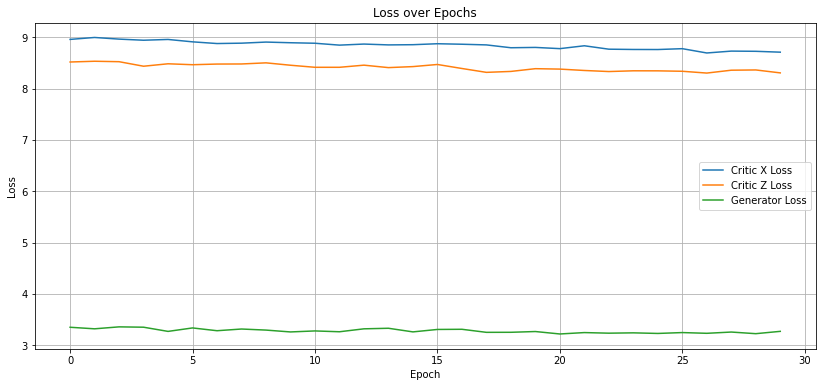

ImportError: `save_weights` requires h5py when saving in hdf5.

In [26]:
# 학습
X = X.reshape((-1, shape[0], feat_dim))  # feat_dim = 주성분 차원
X_ = np.copy(X)
fake = np.ones((batch_size, 1), dtype=np.float32)  # 가짜 레이블 (1)
valid = -np.ones((batch_size, 1), dtype=np.float32)  # 진짜 레이블 (-1)
delta = np.ones((batch_size, 1), dtype=np.float32)  # 델타 (1)

# 손실 값을 저장할 리스트 초기화
e_g_loss = []  # 생성기 손실
e_cx_loss = []  # critic_x 손실
e_cz_loss = []  # critic_z 손실

for epoch in range(1, epochs + 1):
    np.random.shuffle(X_)  # 데이터를 섞음
    epoch_g_loss = []  # 생성기 손실을 저장할 리스트
    epoch_cx_loss = []  # critic_x 손실을 저장할 리스트
    epoch_cz_loss = []  # critic_z 손실을 저장할 리스트
    minibatches_size = batch_size * n_critics
    num_minibatches = int(X_.shape[0] // minibatches_size)
    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size:(i + 1) * minibatches_size]
        # 크리틱 학습
        critic_x.trainable = True
        critic_z.trainable = True
        generator.trainable = False
        encoder.trainable = False
        for j in range(n_critics):
            x = minibatch[j * batch_size:(j + 1) * batch_size]
            z = np.random.normal(size=(batch_size, latent_dim, 1))
            epoch_cx_loss.append(critic_x_train_on_batch(x, z, valid, fake, delta))
            epoch_cz_loss.append(critic_z_train_on_batch(x, z, valid, fake, delta))
        critic_x.trainable = False
        critic_z.trainable = False 
        generator.trainable = True
        encoder.trainable = True 
        # 인코더와 생성기 학습
        epoch_g_loss.append(enc_gen_train_on_batch(x, z, valid))
    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, g_loss))
    e_cx_loss.append(np.mean(np.array(epoch_cx_loss), axis=0))
    e_cz_loss.append(np.mean(np.array(epoch_cz_loss), axis=0))
    e_g_loss.append(np.mean(np.array(epoch_g_loss), axis=0))


# 손실 변화를 그래프로 그리기
plt.figure(figsize=(14, 6))
plt.plot(e_cx_loss, label='Critic X Loss')
plt.plot(e_cz_loss, label='Critic Z Loss')
plt.plot(e_g_loss, label='Generator Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

critic_x_model.save_weights(os.path.join(ckpt_dir, 'critic_x_model.h5'), save_format='h5')
critic_z_model.save_weights(os.path.join(ckpt_dir, 'critic_z_model.h5'), save_format='h5')
encoder_generator_model.save_weights(os.path.join(ckpt_dir, 'encoder_generator_model.h5'), save_format='h5')

## [단계 ⑥] 테스트 데이터에 대한 계산 수행
⑥-1. 테스트 데이터에 대한 계산 수행
- 예측 함수 predict()를 정의한다. 이 함수는 입력 데이터에 encoder-generator 네트워크를 작용하여 재현된 데이터 y_hat을 출력하고 또한 critic_x 판별자 값을 출력한다.

In [27]:
def predict(X):
    """초기 설정된 객체를 사용하여 값을 예측.
    Args:
    X (ndarray): 모델을 위한 입력 시퀀스를 포함하는 N차원 배열.
    Returns:
    ndarray:
    각 입력 시퀀스에 대한 재구성을 포함하는 N차원 배열.
    ndarray:
    각 입력 시퀀스에 대한 비평 점수를 포함하는 N차원 배열.
    """
    X = X.reshape((-1, shape[0], feat_dim)) # feat_dim : 특징 차원 
    z_ = encoder.predict(X)
    y_hat = generator.predict(z_)
    critic = critic_x.predict(X)
    return y_hat, critic
print("predict() 정의: 완료")

predict() 정의: 완료


- 미리 준비된 테스트 데이터 파일 “./data/preprocessed/test/Test07_NG_dchg.csv”와 anomaly 파일인 “./data/preprocessed/test/Test07_NG_dchg_Label.csv”를 지정한다.

In [28]:
# 테스트 데이터를 이용한 예측
# 테스트 데이터 불러오기
args=arguments(signal_file='../../data/preprocessed/test/Test07_NG_dchg.csv',
    timest_form=0,
    anomaly_file='../../data/preprocessed/test/Test07_NG_dchg_Label.csv',
    mode='predict',
    aggregate_interval=1,
    regate_interval=1)
print("argments for prediction mode")
print("----------------------")
print("args.timest_form :", args.timest_form)
print("args.signal_file :", args.signal_file)
print("args.anomaly_file :", args.anomaly_file)
print("args.mode :", args.mode)
print("args.aggregate_interval :", args.aggregate_interval)
print("----------------------\n")

argments for prediction mode
----------------------
args.timest_form : 0
args.signal_file : ../../data/preprocessed/test/Test07_NG_dchg.csv
args.anomaly_file : ../../data/preprocessed/test/Test07_NG_dchg_Label.csv
args.mode : predict
args.aggregate_interval : 1
----------------------



In [29]:
file_path = args.signal_file 
df_test1 = pd.read_csv(file_path) # 테스트 데이터 데이터 프레임 형태로 읽기

In [30]:
######## PCA를 이용한 차원 축소 ########
data_0 = df_test1 # 복제
# (lags_n=0, diffs_n=0, smooth_n=0)
data_1 = diff_smooth_df(data_0, lags_n, diffs_n, smooth_n)
pca = PCA(n_components=features_dim)
data = pca.fit_transform(data_1) # PCA를 이용한 차원 축소
df_1 = []
for i in range(len(data)):
    row=[i+1] # 정수 인덱스 부여
    for jj in range(features_dim):
        row.append(data[i][jj])
    df_1.append(row)
df = pd.DataFrame(df_1)
columns_new = ['date']
for i in range(1, features_dim+1):
    pca_i = 'pca_%s' % str(i)
    columns_new.append(pca_i)
df.columns=columns_new
print("After PCA reduction of test data df.shape = ", df.shape)
print("----------------------")
print(df.head(5))
print("----------------------")
print("\n")

After PCA reduction of test data df.shape =  (4594, 4)
----------------------
   date     pca_1     pca_2     pca_3
0     1 -0.412384  0.583294  0.027636
1     2 -0.406828  0.567897  0.026531
2     3 -0.368964  0.575908  0.015944
3     4 -0.430935  0.547518  0.026097
4     5 -0.425375  0.532121  0.025034
----------------------




- MTadGAN 모형에 입력하기 위하여 테스트 데이터에 대한 집합화(aggregate)를 수행한다. time_segments_aggregate() 함수에 대해서는 위의 코드를 참조한다.

In [31]:
# 시간 집합화 수행
#
X, index = time_segments_aggregate(df, interval=args.aggregate_interval, time_column='date')
print("Test signal data (after time_segments_aggregate) = ", X.shape)
print("----------------------")
print(X[:5])
print("----------------------")
print("\n")

Test signal data (after time_segments_aggregate) =  (4594, 3)
----------------------
[[-0.41238433  0.58329384  0.02763632]
 [-0.40682767  0.56789719  0.02653118]
 [-0.36896407  0.57590827  0.01594388]
 [-0.43093477  0.54751791  0.02609742]
 [-0.42537477  0.532121    0.02503421]]
----------------------




- 스케일링에 의한 정규화 과정을 수행한다. 테스트 데이터를 [-1,+1] 구간 안의 값으로 정규화한다. 

In [32]:
# 최대 - 최소 정규화 적용
X = SimpleImputer().fit_transform(X)
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
print("Test X (after MinMaxScaler) = ", X.shape)
print("----------------------")
print(X[:5])
print("----------------------")
print("\n")

Test X (after MinMaxScaler) =  (4594, 3)
----------------------
[[-0.98179729  1.          0.02048554]
 [-0.97807573  0.96581515  0.01806001]
 [-0.95271668  0.98360199 -0.0051768 ]
 [-0.9942214   0.9205675   0.01710801]
 [-0.99049761  0.88638206  0.01477449]]
----------------------




- MTadGAN의 구조에 맞게 입력할 수 있도록 테스트 데이터에 rolling_window_sequences() 함수를 적용하여 이웃하는 데이터 값으로 윈도우 길이(win_size=10)만큼씩 묶어서 저장한다.

In [33]:
# rolling window sequences 처리
X, y, X_index, y_index = rolling_window_sequences(X, index, window_size= win_size,
 target_size=1, step_size=1, target_column=0 ) 
print("X shape (after rolling_window_seq): {}".format(X.shape))
print("X : ")
print(X[:3, :5])
print("X index shape: {}".format(X_index.shape))
print("y shape: {}".format(y.shape))
print("y : ")
print(y[:5])
print("y index shape: {}".format(y_index.shape))
print("\n")

X shape (after rolling_window_seq): (4584, 10, 3)
X : 
[[[-9.81797293e-01  1.00000000e+00  2.04855446e-02]
  [-9.78075731e-01  9.65815151e-01  1.80600115e-02]
  [-9.52716680e-01  9.83601990e-01 -5.17680170e-03]
  [-9.94221404e-01  9.20567495e-01  1.71080054e-02]
  [-9.90497609e-01  8.86382057e-01  1.47744879e-02]]

 [[-9.78075731e-01  9.65815151e-01  1.80600115e-02]
  [-9.52716680e-01  9.83601990e-01 -5.17680170e-03]
  [-9.94221404e-01  9.20567495e-01  1.71080054e-02]
  [-9.90497609e-01  8.86382057e-01  1.47744879e-02]
  [-9.60544141e-01  9.71167281e-01 -9.41993104e-04]]

 [[-9.52716680e-01  9.83601990e-01 -5.17680170e-03]
  [-9.94221404e-01  9.20567495e-01  1.71080054e-02]
  [-9.90497609e-01  8.86382057e-01  1.47744879e-02]
  [-9.60544141e-01  9.71167281e-01 -9.41993104e-04]
  [-9.79474891e-01  9.25992926e-01  1.28564552e-02]]]
X index shape: (4584,)
y shape: (4584, 1)
y : 
[[-0.97946451]
 [-0.99049122]
 [-0.99048524]
 [-0.97807193]
 [-0.97945812]]
y index shape: (4584,)




- MTadGAN에서의 Anomaly 클래스 및 이상탐지 관련 속성 함수들을 정의한다. 여기서는 Anomaly 클래스에서 주로 쓰이는 주요한 속성함수에 대하여 간략하게 설명한다. 각 함수의 입력 변수는 생략한다.  
    - _find_threshold() : 에러 값들로부터 최적의 threshold 값을 찾는다.
    - _fixed_threshold() : 입력 k 변수의 값에 따라 에러의 threshold를 구한다.
    - _compute_scores() : Anomaly score를 계산한다.
    - _find_window_sequences() : 연속된 이상 값들의 sequence를 찾는다.
    - find_anomalies() : 이상 값을 가지는 연속된 에러값의 sequence를 찾는다.
    - _compute_critic_score() : 판별자 score에서 얻는 이상 값의 배열을 계산한다. 
    - _reconstruction_errors() : 데이터 재현 에러 값을 계산한다. 이는 입력 데이터와 y_hat 사이의차이값으로부터 구해진다.
    - score_anomalies() : 판별자 score와 재현 에러의 결합으로 최종 이상 score를 얻는다.


In [34]:
"""
시계열 이상 탐지 함수.
일부 구현은 논문 https://arxiv.org/pdf/1802.04431.pdf을 참고하였습니다.
"""
class Anomaly(object):
    def __init__(self):
        pass
    
    # _count_above(2)에서 사용
    def _deltas(self, errors, epsilon, mean, std):
        """
        평균 및 표준편차 델타를 계산.
        delta_mean = mean(errors) - epsilon(임계값) 이하의 모든 오류들의 평균
        delta_std = std(errors) - epsilon(임계값) 이하의 모든 오류들의 표준편차

        Args:
        errors (ndarray): 오류 배열. 각 요소는 특정 시간에 발생한 오류 값을 나타냄.
        epsilon (float): 임계값. 이 값 이하의 오류들만을 고려하여 델타를 계산함.
        mean (float): 전체 오류들의 평균 값.
        std (float): 전체 오류들의 표준편차 값.

        Returns:
        float, float:
        * delta_mean: mean에서 epsilon 이하의 오류들의 평균을 뺀 값.
        * delta_std: std에서 epsilon 이하의 오류들의 표준편차를 뺀 값.
        """
        # 오류 배열에서 epsilon 이하의 값들만 추출.
        below = errors[errors <= epsilon]
        
        # epsilon 이하의 오류가 없을 경우 0, 0을 반환.
        if not len(below):
            return 0, 0
        
        # delta_mean: 전체 오류 평균에서 epsilon 이하 오류들의 평균을 뺀 값.
        # delta_std: 전체 오류 표준편차에서 epsilon 이하 오류들의 표준편차를 뺀 값.
        return mean - below.mean(), std - below.std()

    
    # anomalies.py (2) - _z_cost(3)에서 사용
    def _count_above(self, errors, epsilon):
        """epsilon 이상인 오류와 연속된 시퀀스의 수를 계산
        연속된 시퀀스는 시프트하고 원래 값이 true였던 위치의 변화를
        계산하여 그 위치에서 시퀀스가 시작되었음을 의미
        Args:
        errors (ndarray): 오류 배열.
        epsilon (ndarray): 임계값.
        Returns:
        int, int:
        * epsilon 이상인 오류의 수.
        * epsilon 이상인 연속된 시퀀스의 수.
        """
        # errors 배열에서 epsilon보다 큰 값인지 여부 (True/False) 배열
        above = errors > epsilon
        # epsilon보다 큰 오류의 총 수를 계산
        total_above = len(errors[above])
        # above 배열을 pandas Series 데이터 타입으로 변환
        above = pd.Series(above)
        # above Series를 1만큼 시프트(레코드를 한 칸씩 밈)
        shift = above.shift(1)
        # above와 shift된 값 간의 변화를 계산(서로 다른 경우가 true)
        change = above != shift
        # epsilon보다 큰 연속된 시퀀스의 수를 계산
        total_consecutive = sum(above & change)
        # 결과를 반환
        return total_above, total_consecutive
    
    # anomalies.py (3) - _find_threshold(4)에서 사용
    def _z_cost(self, z, errors, mean, std):
        """z 값이 얼마나 나쁜지를 계산
        원래 공식::
        (delta_mean/mean) + (delta_std/std)
        ------------------------------------------------------
        number of errors above + (number of sequences above)^2
        이는 `z`의 "좋음"을 계산하며, 값이 높을수록 `z`가 더 좋다는 것을 의미
        이 경우, 이 값을 반전(음수로 만듦)하여 비용 함수로 변환
        나중에 scipy.fmin을 사용하여 이를 최소화
        
        Args:
        z (ndarray): 비용 점수가 계산될 값.
        errors (ndarray): 오류 배열.
        mean (float): 오류들의 평균.
        std (float): 오류들의 표준편차.
        
        Returns float: z의 비용.
        """
        
        # epsilon 값을 평균 + z * 표준편차로 계산
        epsilon = mean + z * std
        # epsilon을 사용하여 평균 및 표준편차 델타를 계산
        delta_mean, delta_std = self._deltas(errors, epsilon, mean, std)
        # epsilon보다 큰 오류의 개수와 해당 시퀀스의 수를 계산
        above, consecutive = self._count_above(errors, epsilon)
        # 분자(numerator)를 계산합니다. (반전된 값)
        numerator = -(delta_mean / mean + delta_std / std)
        # 분모(denominator)를 계산합니다.
        denominator = above + consecutive ** 2
        # 분모가 0이면 무한대를 반환
        if denominator == 0:
            return np.inf
        
        # 최종 비용을 계산하여 반환
        return numerator / denominator
    # anomalies.py (4) - _find_window_sequences(9)에서 사용
    def _find_threshold(self, errors, z_range):
        """이상적인 임계값 찾는 함수.
        이상적인 임계값은 z_cost 함수를 최소화하는 값.
        Scipy.fmin을 사용하여 z_range의 값들을 시작점으로 최소값을 탐색.

        Args:
        errors (ndarray): 오류 배열.
        z_range (list): scipy.fmin 함수의 시작점을 선택할 범위를 나타내는 두 값의 리스트.

        Returns: float: 계산된 임계값.
        """
        # 오류들의 평균을 계산.
        mean = errors.mean()
        
        # 오류들의 표준편차를 계산.
        std = errors.std()
        
        # z_range에서 최소값과 최대값을 가져옴.
        min_z, max_z = z_range
        
        # 최적의 z값을 저장할 변수 초기화.
        best_z = min_z
        
        # 최적의 비용을 무한대로 초기화.
        best_cost = np.inf

        # min_z부터 max_z까지 반복.
        for z in range(min_z, max_z):
            # fmin 함수를 사용하여 z에서 시작하는 최소 비용을 찾음.
            best = fmin(self._z_cost, z, args=(errors, mean, std), full_output=True, disp=False)
            
            # 최적의 z값과 비용을 가져옴.
            z, cost = best[0:2]
            
            # 현재 비용이 최적의 비용보다 작으면 갱신.
            if cost < best_cost:
                best_z = z[0]

        # 최적의 임계값을 계산하여 반환.
        return mean + best_z * std

    # _find_window_sequences(9)에서 사용
    def _fixed_threshold(self, errors, k=3.0):
        """임계값 계산.
        고정된 임계값은 평균에서 k 표준편차만큼 떨어진 값으로 정의됨.

        Args:
        errors (ndarray): 오류 배열.

        Returns:
        float: 계산된 임계값.
        """
        # 오류들의 평균을 계산.
        mean = errors.mean()
        
        # 오류들의 표준편차를 계산.
        std = errors.std()

        # 고정된 임계값을 계산하여 반환.
        return mean + k * std
    
    # anomalies.py (5-1) - _find_window_sequences(9)에서 사용
    def _find_sequences(self, errors, epsilon, anomaly_padding):
        """epsilon 이상인 값들의 시퀀스 탐색.
        다음 단계들을 따름:
        * epsilon 이상인 값을 표시하는 불리언 마스크 생성.
        * True 값 주위의 일정 범위의 오류를 True로 표시.
        * 이 마스크를 한 칸씩 시프트하고, 빈 공간은 False로 채움.
        * 시프트된 마스크와 원래 마스크를 비교하여 변화가 있는지 확인.
        * True였던 값이 변경된 지점을 시퀀스 시작으로 간주.
        * False였던 값이 변경된 지점을 시퀀스 종료로 간주.

        Args:
        errors (ndarray): 오류 배열.
        epsilon (float): 임계값. epsilon 이상의 모든 오류는 이상으로 간주.
        anomaly_padding (int): 발견된 이상 주위에 추가할 오류의 개수.

        Returns:
        ndarray, float:
        * 발견된 이상 시퀀스의 시작과 끝을 포함하는 배열.
        * 이상으로 간주되지 않은 최대 오류 값.
        """
        # epsilon 이상인 값을 표시하는 불린 마스크 생성.
        above = pd.Series(errors > epsilon)

        # True인 값의 인덱스를 찾음.
        index_above = np.argwhere(above.values)

        # True 값 주위의 일정 범위의 오류를 True로 표시.
        for idx in index_above.flatten():
            above[max(0, idx - anomaly_padding):min(idx + anomaly_padding + 1, len(above))] = True

        # 이 마스크를 한 칸씩 시프트하고, 빈 공간은 False로 채움.
        shift = above.shift(1).fillna(False)

        # 시프트된 마스크와 원래 마스크를 비교하여 변화가 있는지 확인.
        change = above != shift

        # 모든 값이 True이면 max_below는 0으로 설정.
        if above.all():
            max_below = 0
        else:
            # 이상으로 간주되지 않은 최대 오류 값을 찾음.
            max_below = max(errors[~above])

        # 시퀀스의 시작과 끝 인덱스를 찾음.
        index = above.index
        starts = index[above & change].tolist()
        ends = (index[~above & change] - 1).tolist()

        # 마지막 시퀀스가 종료되지 않았을 경우 종료 인덱스를 추가.
        if len(ends) == len(starts) - 1:
            ends.append(len(above) - 1)

        # 결과를 배열로 반환.
        return np.array([starts, ends]).T, max_below

    # anomalies.py (5-2) - _find_window_sequences(9)에서 사용
    def _get_max_errors(self, errors, sequences, max_below):
        """
        각 이상 시퀀스의 최대 오류를 가져옴.
        또한 이상으로 간주되지 않은 최대 오류 값을 포함하는 행을 추가.
        각 시퀀스의 최대 오류를 포함하는 ``max_error`` 열과 시작 및 종료 인덱스를
        포함하는 ``start`` 및 ``stop`` 열이 있는 테이블을 내림차순으로 정렬하여 반환.

        Args:
        errors (ndarray): 오류 배열. 각 요소는 특정 시간에 발생한 오류 값을 나타냄.
        sequences (ndarray): 이상 시퀀스의 시작과 끝 인덱스를 포함하는 2차원 배열.
        max_below (float): 이상으로 간주되지 않은 최대 오류 값.

        Returns:
        pandas.DataFrame: ``start``, ``stop``, ``max_error`` 열을 포함하는 DataFrame 객체.
                        ``start``와 ``stop``은 각 시퀀스의 시작과 끝 인덱스,
                        ``max_error``는 해당 시퀀스 내의 최대 오류 값.
        """
        # max_errors 리스트를 초기화하고, 이상으로 간주되지 않은 최대 오류 값을 첫 번째 항목으로 추가.
        max_errors = [{
            'max_error': max_below,
            'start': -1,
            'stop': -1
        }]

        # 각 시퀀스를 순회하며 최대 오류 값을 계산하고 max_errors 리스트에 추가.
        for sequence in sequences:
            start, stop = sequence  # 시퀀스의 시작과 끝 인덱스
            sequence_errors = errors[start: stop + 1]  # 해당 시퀀스의 오류 값들
            max_errors.append({
                'start': start,  # 시퀀스의 시작 인덱스
                'stop': stop,    # 시퀀스의 끝 인덱스
                'max_error': max(sequence_errors)  # 시퀀스 내의 최대 오류 값
            })

        # max_errors 리스트를 DataFrame으로 변환하고, 'max_error' 열을 기준으로 내림차순 정렬.
        max_errors = pd.DataFrame(max_errors).sort_values('max_error', ascending=False)

        # 정렬된 DataFrame의 인덱스를 재설정하여 반환.
        return max_errors.reset_index(drop=True)

    
    # anomalies.py (6) - _find_window_sequences(9)에서 사용
    def _prune_anomalies(self, max_errors, min_percent):
        """거짓 양성을 줄이기 위해 이상을 가지치기.
        다음 단계들을 따름:
        * 오류를 1단계 음수 방향으로 시프트하여 각 값을 다음 값과 비교.
        * 비교하지 않기 위해 마지막 행을 제거.
        * 각 행에 대한 백분율 증가를 계산.
        * ``min_percent`` 이하인 행을 찾음.
        * 이러한 행 중 가장 최근의 행의 인덱스를 찾음.
        * 해당 인덱스 위의 모든 시퀀스 값을 가져옴.

        Args:
        max_errors (pandas.DataFrame): ``start``, ``stop``, ``max_error`` 열을 포함하는 DataFrame 객체.
        min_percent (float):
        이상 간의 분리를 위한 최소 백분율. 윈도우 시퀀스에서 가장 높은 비이상 오류와의 비교.

        Returns:
        ndarray: 가지치기된 이상들의 시작, 끝, max_error를 포함하는 배열.
        """
        # 오류를 1단계 음수 방향으로 시프트하여 다음 값과 비교.
        next_error = max_errors['max_error'].shift(-1).iloc[:-1]

        # 현재 오류 값을 가져옴.
        max_error = max_errors['max_error'].iloc[:-1]

        # 각 행에 대한 백분율 증가를 계산.
        increase = (max_error - next_error) / max_error

        # min_percent 이하인 행을 찾음.
        too_small = increase < min_percent

        # 모든 행이 min_percent 이하인 경우.
        if too_small.all():
            last_index = -1
        else:
            # min_percent 이상인 가장 최근의 행의 인덱스를 찾음.
            last_index = max_error[~too_small].index[-1]

        # 가지치기된 이상들의 시작, 끝, max_error를 포함하는 배열을 반환.
        return max_errors[['start', 'stop', 'max_error']].iloc[0: last_index + 1].values
    
    # anomalies.py (7) - _find_window_sequences(9)에서 사용
    def _compute_scores(self, pruned_anomalies, errors, threshold, window_start):
        """이상치 점수를 계산.
        시퀀스에서 최대 오차에 비례하는 점수를 계산하고, 인덱스를 절대값으로 만들기 위해 window_start 타임스탬프를 추가.

        Args:
        pruned_anomalies (ndarray): 윈도우 내 모든 이상의 시작, 끝 및 max_error를 포함하는 이상 배열.
        errors (ndarray): 오차 배열.
        threshold (float): 임계값.
        window_start (int): 윈도우에서 첫 번째 오차 값의 인덱스.

        Returns:
        list: 각 이상에 대해 시작 인덱스, 종료 인덱스, 점수를 포함하는 이상 목록.
        """
        # 이상 배열 선언
        anomalies = list()

        # 점수 계산을 위한 분모부. 오차의 평균과 표준편차의 합으로 계산.
        denominator = errors.mean() + errors.std()

        # 가지치기된 각 이상에 대해 점수를 계산.
        for row in pruned_anomalies:
            max_error = row[2]

            # 점수를 계산. (max_error - threshold) / 분모
            score = (max_error - threshold) / denominator

            # 절대 인덱스를 사용하여 이상을 추가.
            anomalies.append([row[0] + window_start, row[1] + window_start, score])

        # 계산된 점수가 포함된 이상 목록을 반환.
        return anomalies
    
    # anomalies.py (8) - find_anomalies(10)에서 사용
    def _merge_sequences(self, sequences):
        """연속적이고 겹치는 시퀀스를 병합함.
        시작, 종료, 점수 트리플의 리스트를 반복하면서
        겹치거나 연속적인 시퀀스를 병합함.
        병합된 시퀀스의 점수는 각 시퀀스의 길이로 가중치를 둔
        단일 점수의 평균임.
        
        Args:
        sequences (list): 각 이상치의 시작 인덱스, 종료 인덱스, 점수를 포함하는 이상치 목록.
        
        Returns:
        ndarray: 병합 후 각 이상치의 시작 인덱스, 종료 인덱스, 점수를 포함하는 배열.
        """
        
        # 시퀀스가 비어있는 경우 빈 배열 반환
        if len(sequences) == 0:
            return np.array([])
        
        # 시퀀스를 시작 인덱스만을 기준으로 정렬
        # 매개변수를 설정하지 않는 경우 시작 인덱스가 같으면 다음 원소를 비교
        # 매개변수를 설정한 경우 시작 인덱스가 같으면 기존에 정렬된 순서대로 정렬
        sorted_sequences = sorted(sequences, key=lambda entry: entry[0])
        
        # 병합된 새로운 시퀀스 초기화
        new_sequences = [sorted_sequences[0]] 
        score = [sorted_sequences[0][2]]  # 첫 시퀀스의 점수
        weights = [sorted_sequences[0][1] - sorted_sequences[0][0]]  # 첫 시퀀스의 길이(가중치)
        
        # 정렬된 시퀀스를 순회하면서 병합
        for sequence in sorted_sequences[1:]:
            prev_sequence = new_sequences[-1]  # prev_sequence는 마지막으로(바로 이전에) 병합 혹은 추가된 시퀀스
            
            # 현재 순회하는 시퀀스의 시작 인덱스가 prev_sequence의 종료 인덱스와 겹치거나 바로 연속적인 경우
            if sequence[0] <= prev_sequence[1] + 1:
                score.append(sequence[2])                   # 현재 시퀀스의 점수를 추가
                weights.append(sequence[1] - sequence[0])   # 현재 시퀀스의 길이(가중치)를 추가
                # 점수 가중 평균 계산(가중치는 각 시퀀스의 길이만큼 줌)
                weighted_average = np.average(score, weights=weights)
                # 이전 시퀀스와 병합
                new_sequences[-1] = (prev_sequence[0],                      # 시작 인덱스는 이전 시퀀스의 시작 인덱스
                                    max(prev_sequence[1], sequence[1]),     # 종료 인덱스는 두 시퀀스 중 최댓값
                                    weighted_average)                       # 점수는 가중평균을 주어 계산한 값
            else:
                # 현재 시퀀스가 이전 시퀀스와 겹치지 않으면 새로운 시퀀스로 추가
                score = [sequence[2]]                   # 현재 시퀀스의 점수 초기화
                weights = [sequence[1] - sequence[0]]   # 현재 시퀀스의 길이 초기화
                new_sequences.append(sequence)          # 새로운 시퀀스에 추가
        
        return np.array(new_sequences)  # 병합 작업이 완료된 시퀀스를 배열로 반환
    
    # anomalies.py (9) - find_anomalies(10)에서 사용
    def _find_window_sequences(self, window, z_range, anomaly_padding, min_percent, window_start, fixed_threshold):
        """이상치인 값들의 시퀀스를 찾음.
        먼저 윈도우의 임계값을 찾고, 그 임계값 이상인 모든 시퀀스를 찾음.
        그런 다음 시퀀스의 최대 오류를 얻고 이상치를 가지치기함.
        마지막으로, 이상치의 점수를 계산함.
        Args:
        window (ndarray): 분석 중인 윈도우의 오류 배열.
        z_range (list): 동적 임계값 찾기 함수의 시작점을 선택할 범위를 나타내는 두 값의 리스트.
        anomaly_padding (int): 발견된 이상치 전후의 오류 수를 이상치 시퀀스에 추가.
        min_percent (float): 윈도우 시퀀스의 가장 높은 비이상치 오류와 이상치 간의 분리 비율.
        window_start (int): 윈도우에서 첫 번째 오류 값의 인덱스.
        fixed_threshold (bool): 고정 임계값을 사용할지 동적 임계값을 사용할지 여부를 나타냄.
        Returns:
        
        window_sequences (ndarray): 윈도우에서 발견된 각 이상치 시퀀스의 시작 인덱스, 종료 인덱스, 점수를 포함하는 배열.
        """
        
        # 고정 임계값을 사용할지 여부에 따라 임계값 결정(기본값 true)
        if fixed_threshold: 
            threshold = self._fixed_threshold(window)           # 고정 임계값 사용
        else:
            threshold = self._find_threshold(window, z_range)   # 동적 임계값 사용
        
        # 임계값을 기준으로 윈도우에서 이상치 시퀀스(window_sequences)와 비이상치 중 최대값(max_below)을 찾음(#5-1)
        window_sequences, max_below = self._find_sequences(window, threshold, anomaly_padding)
        
        # 시퀀스에서 최대 오류를 계산(#5-2)
        max_errors = self._get_max_errors(window, window_sequences, max_below)
        
        # 이상치 가지치기 (유의미한 이상치만 남김)(min_percent 기본값 0.1)
        pruned_anomalies = self._prune_anomalies(max_errors, min_percent)
        
        # 가지치기된 각 이상치 시퀀스의 점수를 계산(점수가 포함된 이상치 시퀀스를 반환받음)
        window_sequences = self._compute_scores(pruned_anomalies, window, threshold, window_start)
        
        return window_sequences  # 이상치 시퀀스를 반환

    
    # anomalies.py (10-1)
    def find_anomalies(self, errors, index, z_range=(0, 10), window_size=None, window_size_portion=None, window_step_size=None, 
                    window_step_size_portion=None, min_percent=0.1, anomaly_padding=50, lower_threshold=False, fixed_threshold=True):
        """오류 값들의 시퀀스에서 이상치를 찾음.
        오류 윈도우을 정의하고, 그 윈도우에서 이상치 시퀀스를 찾아 시작/종료 인덱스와 점수를 저장함.
        오류 시퀀스를 평균을 중심으로 반전시켜 비정상적으로 낮은 오류 시퀀스를 찾을 수도 있음.
        윈도우을 이동하면서 이 절차를 반복함.
        마지막으로, 중복되거나 연속적인 시퀀스를 결합함.
        Args:
        errors (ndarray): 오류 배열.
        index (ndarray): 오류 인덱스 배열.
        z_range (list):
        선택사항. scipy.fmin 함수의 시작점을 선택할 범위를 나타내는 두 값의 리스트.
        주어지지 않으면 (0, 10)이 사용됨.
        window_size (int):
        선택사항. 임계값이 계산되는 윈도우의 크기.
        주어지지 않으면 `None`이 사용되며, 전체 오류 시퀀스에 대한 하나의 임계값이 사용됨.
        window_size_portion (float):
        선택사항. 오류 시퀀스의 일부로 윈도우 크기를 지정함.
        주어지지 않으면 `None`이 사용되며, 윈도우 크기는 그대로 사용됨.
        window_step_size (int):
        선택사항. 윈도우을 이동시키기 전의 단계 수.
        window_step_size_portion (float):
        선택사항. 윈도우 크기의 일부로 단계 수를 지정함.
        주어지지 않으면 `None`이 사용되며, 윈도우 단계 크기는 그대로 사용됨.
        min_percent (float):
        선택사항. 이상치와 윈도우 시퀀스에서 가장 높은 비이상치 오류 간의 분리 비율.
        주어지지 않으면 0.1이 사용됨.
        anomaly_padding (int):
        선택사항. 발견된 이상치 전후의 오류 수를 이상치 시퀀스에 추가함.
        주어지지 않으면 50이 사용됨.
        lower_threshold (bool):
        선택사항. 비정상적으로 낮은 오류를 찾기 위해 낮은 임계값을 적용할지 여부를 나타냄.
        주어지지 않으면 `False`가 사용됨.
        fixed_threshold (bool):
        선택사항. 고정 임계값을 사용할지 동적 임계값을 사용할지 여부를 나타냄.
        주어지지 않으면 `False`가 사용됨.
        Returns:
        ndarray: 시작 인덱스, 종료 인덱스, 점수를 포함하는 각 이상치 시퀀스 배열.
        """
        # 윈도우 크기를 설정, 주어지지 않으면 전체 오류 배열의 길이로 설정
        window_size = window_size or len(errors)
        if window_size_portion:
            # 오류 배열 길이의 비율로 윈도우 크기를 설정
            window_size = np.ceil(len(errors) * window_size_portion).astype('int')
        
        # 윈도우 이동 단계 크기 설정, 주어지지 않으면 윈도우 크기와 동일하게 설정
        window_step_size = window_step_size or window_size
        if window_step_size_portion:
            # 윈도우 크기의 비율로 윈도우 이동 단계를 설정
            window_step_size = np.ceil(window_size * window_step_size_portion).astype('int')
        
        window_start = 0  # 윈도우 시작점 초기화
        window_end = 0  # 윈도우 종료점 초기화
        sequences = list()  # 이상치 시퀀스를 저장할 리스트 초기화
        
        # 오류 배열을 순회하며 윈도우를 이동시키는 루프
        while window_end < len(errors):
            window_end = window_start + window_size  # 윈도우 종료점 설정
            window = errors[window_start:window_end]  # 현재 윈도우에 해당하는 오류 값들을 선택
            
            # 현재 윈도우에서 이상치 시퀀스를 찾음(#9번 참고)
            window_sequences = self._find_window_sequences(window,
                                                        z_range,
                                                        anomaly_padding,
                                                        min_percent,
                                                        window_start,
                                                        fixed_threshold)
            sequences.extend(window_sequences)  # 찾은 시퀀스를 sequences 리스트에 추가
            
            if lower_threshold:
                # 오류 시퀀스를 평균을 기준으로 반전
                mean = window.mean()
                inverted_window = mean - (window - mean)
                
                # 반전된 오류 시퀀스에서 이상치 시퀀스를 찾음
                inverted_window_sequences = self._find_window_sequences(inverted_window,
                                                                        z_range,
                                                                        anomaly_padding,
                                                                        min_percent,
                                                                        window_start,
                                                                        fixed_threshold)
                sequences.extend(inverted_window_sequences)  # 찾은 시퀀스를 sequences 리스트에 추가
            
            window_start = window_start + window_step_size  # 윈도우 시작점을 이동
        
        # 중복되거나 연속적인 시퀀스를 병합
        sequences = self._merge_sequences(sequences)
        
        anomalies = list()  # 이상치를 저장할 리스트 초기화
        for start, stop, score in sequences:
            # 각 이상치 시퀀스의 시작 인덱스, 종료 인덱스, 점수를 출력하고 리스트에 추가
            print("start", start)
            print("stop", stop)
            print("score", score)
            anomalies.append([index[int(start)], index[int(stop)], score])
        
        return anomalies  # 이상치 리스트 반환
    
    # anomalies.py (11) score_anomalies(17)에서 사용
    def _compute_critic_score(self, critics, smooth_window):
        """Critic 점수를 계산하여 이상 점수 배열을 반환한다.
        Args:
        critics (ndarray): Critic 값 배열.
        smooth_window (int): 오류를 평활화할 때 사용되는 윈도우 크기.
        Returns:
        ndarray: 이상 점수 배열.
        """
        
        # critics를 numpy 배열로 변환
        critics = np.asarray(critics)
        
        # 1사분위수와 3사분위수를 계산
        l_quantile = np.quantile(critics, 0.25)
        u_quantile = np.quantile(critics, 0.75)
        
        # critics 값이 1사분위수와 3사분위수 사이에 있는지 여부를 나타내는 True, False 배열을 생성
        in_range = np.logical_and(critics >= l_quantile, critics <= u_quantile)
        
        # 1사분위수와 3사분위수 사이에 있는 critics 값의 평균을 계산
        critic_mean = np.mean(critics[in_range])
        
        # critics 값의 전체 표준 편차를 계산
        critic_std = np.std(critics)
        # (X - 평균) / (표준편차)
        # critics 값을 표준화하여 z-score의 절댓값을 계산하고, 1을 더해 양수로 변환(값이 0임을 피하기 위해)
        z_scores = np.absolute((np.asarray(critics) - critic_mean) / critic_std) + 1
        
        # z-score를 Series 타입으로 변환하고, smooth_window의 크기만큼의 이동 평균을 계산
        # center = True : 해당 인덱스를 기준으로 계산. False이면 현재위치 포함 이전 smooth_window-1개만큼을 포함하여 계산
        # min_periods : smooth_window 크기에 미치지 못하더라도 smooth_window // 2의 크기가 보장된다면 이동 평균을 계산
        # .values : numpy 배열로 변환
        z_scores = pd.Series(z_scores).rolling(smooth_window, center=True, min_periods=smooth_window // 2).mean().values
        
        # 최종 z-score 배열을 반환
        return z_scores

    
    # anomalies.py (12) - 단독 사용
    def _regression_errors(y, y_hat, smoothing_window=0.01, smooth=True):
        """예측값과 실제값을 비교하여 절대 오차 배열을 계산함.
        만약 smooth가 True라면, 결과 오차 배열에 EWMA를 적용함.

        Args:
            y (ndarray): 실제값 (정답).
            y_hat (ndarray): 예측값.
            smoothing_window (float): 선택사항. smoothing window의 크기. y의 전체 길이의 비율로 표현됨. 기본값은 0.01.
            smooth (bool): 선택사항. 반환된 오차에 EWMA를 적용할지 여부를 나타냄. 기본값은 True.
        Returns:
            ndarray: 오차 배열.
        """
        # 절대 오차를 계산함
        errors = np.abs(y - y_hat)[:, 0]
        
        # smooth가 False라면, 단순히 오차 배열을 반환함
        if not smooth:
            return errors
        
        # smoothing_window를 y의 길이에 비례하여 설정함
        smoothing_window = int(smoothing_window * len(y))
        
        # EWMA를 적용하여 부드러운 오차 배열을 반환함
        return pd.Series(errors).ewm(span=smoothing_window).mean().values
    
    # anomalies.py (13) - 단독 사용
    def regression_errors(y, y_hat, smoothing_window=0.01, smooth=True):
        """예측값과 실제값을 비교하여 절대 오차 배열을 계산함.

        Args:
            y (ndarray): 실제값 (정답).
            y_hat (ndarray): 예측값.
            smoothing_window (float): 선택사항. smoothing window의 크기. y의 전체 길이의 비율로 표현됨. 기본값은 0.01임.
            smooth (bool): 선택사항. 반환된 오차에 EWMA를 적용할지 여부를 나타냄. 기본값은 True임.
        Returns:
            ndarray: 오차 배열.
        """
        # 절대 오차를 계산함
        errors = np.abs(y - y_hat)[:, 0]
        
        # smooth가 False라면, 단순히 오차 배열을 반환함
        if not smooth:
            return errors
        
        # smoothing_window를 y의 길이에 비례하여 설정함
        smoothing_window = int(smoothing_window * len(y))
        
        # EWMA(지수가중이동평균)를 적용하여 부드러운 오차 배열을 반환함
        return pd.Series(errors).ewm(span=smoothing_window).mean().values

    # anomalies.py (14) - _reconstruction_errors(16)에서 사용
    def _point_wise_error(self, y, y_hat):
        """예측 값과 실제 값 간의 점 단위 오류를 계산함.
        Args:
        y (ndarray): 실제 값.
        y_hat (ndarray): 예측 값.
        Returns:
        ndarray: 부드럽게 처리된 점 단위 오류 배열.
        """
        
        y_abs = abs(y - y_hat)              # 실제 값과 예측 값의 차이의 절대값을 계산
        y_abs_sum = np.sum(y_abs, axis=-1)  # 차이의 절대값을 마지막 차원을 따라 합산
        return y_abs_sum                    # 점 단위 오류 값을 반환
    
    # _reconstruction_errors(16)에서 사용
    def _area_error(self, y, y_hat, score_window=10):
        """예측 값과 실제 값 간의 면적 오류를 계산함.
        Args:
        y (ndarray): 실제 값.
        y_hat (ndarray): 예측 값.
        score_window (int):
        선택사항. 점수가 계산되는 윈도우의 크기.
        주어지지 않으면 10이 사용됨.
        Returns:
        ndarray: 면적 오류 배열.
        """
        
        # 실제 값 y를 pandas Series로 변환한 후, 주어진 윈도우 크기(score_window)를 이용하여
        # 중심에서부터 부드럽게 처리하고, trapz 함수를 적용하여 적분값을 계산
        smooth_y = pd.Series(y).rolling(score_window, center=True, 
                                        min_periods=score_window // 2).apply(integrate.trapz)
        
        # 예측 값 y_hat를 pandas Series로 변환한 후, 주어진 윈도우 크기(score_window)를 이용하여
        # 중심에서부터 부드럽게 처리하고, trapz 함수를 적용하여 적분값을 계산
        smooth_y_hat = pd.Series(y_hat).rolling(score_window, center=True, 
                                                min_periods=score_window // 2).apply(integrate.trapz)
        
        # 부드럽게 처리된 실제 값과 예측 값 간의 차이의 절대값을 계산
        errors = abs(smooth_y - smooth_y_hat)
        
        return errors  # 면적 오류 값을 반환
    
    # anomalies.py (15) _reconstruction_errors(16)에서 사용
    def _dtw_error(self, y, y_hat, score_window=10):
        """예측 값과 실제 값 간의 동적 타임 워핑(DTW) 오류를 계산함.
        Args:
        y (ndarray): 실제 값.
        y_hat (ndarray): 예측 값.
        score_window (int):
        선택사항. 점수가 계산되는 윈도우의 크기.
        주어지지 않으면 10이 사용됨.
        Returns:
        ndarray: DTW 오류 배열.
        """
        
        length_dtw = (score_window // 2) * 2 + 1  # DTW 길이를 계산 (score_window가 홀수여야 함)
        half_length_dtw = length_dtw // 2  # DTW 길이의 절반 계산

        # 실제 값 y에 패딩 추가
        y_pad = np.pad(y, (half_length_dtw, half_length_dtw), 'constant', constant_values=(0, 0))
        # 예측 값 y_hat에 패딩 추가
        y_hat_pad = np.pad(y_hat, (half_length_dtw, half_length_dtw), 'constant', constant_values=(0, 0))

        i = 0  # 인덱스 초기화
        similarity_dtw = []  # DTW 유사도를 저장할 리스트 초기화

        # 실제 값과 예측 값 간의 DTW 유사도를 계산
        while i < len(y) - length_dtw:
            true_data = y_pad[i:i + length_dtw]  # 실제 값의 현재 윈도우 선택
            true_data = true_data.flatten()  # 1차원 배열로 변환
            pred_data = y_hat_pad[i:i + length_dtw]  # 예측 값의 현재 윈도우 선택
            pred_data = pred_data.flatten()  # 1차원 배열로 변환
            dist = dtw(true_data, pred_data)  # DTW 유사도 계산
            similarity_dtw.append(dist)  # 계산된 유사도를 리스트에 추가
            i += 1  # 인덱스 증가

        # 오류 값을 계산하여 패딩 추가
        errors = ([0] * half_length_dtw + similarity_dtw + [0] * (len(y) - len(similarity_dtw) - half_length_dtw))

        return errors  # DTW 오류 값을 반환

    
    # anomalies.py (16-1) - score_anomalies(17)에서 사용
    def _reconstruction_errors(self, y, y_hat, step_size=1, score_window=10, smoothing_window=0.01, smooth=True, rec_error_type='point'):
        """재구성 오류 배열을 계산함.
        예상 값과 예측 값 간의 차이를 재구성 오류 유형에 따라 계산함.
        Args:
        y (ndarray): 실제 값.
        y_hat (ndarray): 예측 값. 각 타임스탬프는 여러 예측을 가짐.
        step_size (int): 선택사항. 예측 값의 윈도우 사이의 단계 수를 나타냄. 주어지지 않으면 1이 사용됨.
        score_window (int): 선택사항. 점수가 계산되는 윈도우의 크기. 주어지지 않으면 10이 사용됨.
        smoothing_window (float 또는 int): 선택사항. 부드럽게 하는 윈도우의 크기. float인 경우 y의 총 길이의 비율로 표현됨. 주어지지 않으면 0.01이 사용됨.
        smooth (bool): 선택사항. 반환된 오류가 부드럽게 되어야 하는지 여부를 나타냄. 주어지지 않으면 `True`가 사용됨.
        rec_error_type (str): 선택사항. 재구성 오류 유형 ``["point", "area", "dtw"]``. 주어지지 않으면 "point"가 사용됨.
        Returns:
        ndarray: 재구성 오류 배열.
        """
        # smoothing_window가 float인 경우, y의 길이에 비례하여 정수로 변환하고 최대 200으로 제한
        # smooth 하는데 사용할 윈도우의 크기를 정하는 단계
        # isinstance : 데이터타입 확인 함수
        if isinstance(smoothing_window, float):
            smoothing_window = min(math.trunc(len(y) * smoothing_window), 200)
        
        true = []  # 실제 값들을 저장할 리스트 초기화
        
        # y의 첫 번째 요소를 순서대로 true 리스트에 추가
        for i in range(len(y)):
            true.append(y[i][0])
        
        # 마지막 윈도우의 내용을 포함하여 true 리스트에 추가
        # y의 마지막 값의 전체 값을 순서대로 true 리스트에 추가
        for it in range(len(y[-1]) - 1):
            true.append(y[-1][it + 1])
        
        predictions = []                # 예측 값들을 저장할 리스트 초기화
        predictions_vs = []             # 예측 값들의 통계 정보를 저장할 리스트 초기화
        pred_length = y_hat.shape[1]    # y_hat의 두 번째 차원의 길이 저장(예측 길이)
        num_errors = y_hat.shape[1] + step_size * (y_hat.shape[0] - 1)  # 총 오류 수 계산
        
        # 예측 값들을 계산
        for i in range(num_errors):
            intermediate = []  # 중간 예측 값들을 저장할 리스트 초기화
            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])  # 중간 예측 값들을 intermediate 리스트에 추가
            
            if intermediate:
                predictions.append(np.average(intermediate, axis=0))  # 중간 예측 값들의 평균을 predictions 리스트에 추가
                # intermediate 리스트의 통계 정보(최소, 최대, 1~3사분위수)를 predictions_vs 리스트에 추가
                predictions_vs.append([[np.min(np.asarray(intermediate)), 
                                        np.percentile(np.asarray(intermediate), 25), 
                                        np.percentile(np.asarray(intermediate), 50), 
                                        np.percentile(np.asarray(intermediate), 75), 
                                        np.max(np.asarray(intermediate))]])

        true = np.asarray(true)                     # true(실제 값) 리스트를 numpy 배열로 변환
        predictions = np.asarray(predictions)       # predictions 리스트를 numpy 배열로 변환
        predictions_vs = np.asarray(predictions_vs) # predictions_vs 리스트를 numpy 배열로 변환
        
        # 재구성 오류 계산
        if rec_error_type.lower() == "point":
            errors = self._point_wise_error(true, predictions)          # 점 단위 오류 계산
        elif rec_error_type.lower() == "area":
            errors = self._area_error(true, predictions, score_window)  # 면적 단위 오류 계산
        elif rec_error_type.lower() == "dtw":
            errors = self._dtw_error(true, predictions, score_window)   # 동적 타임 워핑 오류 계산
        
        # 부드럽게 처리
        if smooth:
            errors = pd.Series(errors).rolling(smoothing_window, center=True, 
                                               min_periods=smoothing_window // 2).mean().values  # 오류 값을 부드럽게 처리
        
        return errors, predictions_vs  # 오류 값들과 예측 값들의 통계 정보를 반환
    
    # anomalies.py (17-1)
    def score_anomalies(self, y, y_hat, critic, index, score_window=10, critic_smooth_window=None, 
                    error_smooth_window=None, smooth=True, rec_error_type="point", comb="mult", lambda_rec=0.5):
        """anomaly score 배열을 계산.
        anomaly score는 재현 오류와 critic 점수를 합하여 계산
        Args:
        y (ndarray): 실제 값 Ground truth.
        y_hat (ndarray): 예측 값. 각 시간마다 여러 예측 값을 가짐
        index (ndarray): 각 y에 대한 시간 인덱스(window의 시작 위치)
        critic (ndarray): Critic 점수. 각 시점마다 여러 critic 점수를 가짐
        score_window (int): 선택사항. 점수가 계산되는 window의 사이즈. 지정되지 않으면 10이 사용됨.
        critic_smooth_window (int): 선택사항. critic 점수에 평활화가 적용되는 window의 크기. 지정되지 않으면 200이 사용됨.
        error_smooth_window (int): 선택사항. error에 평활화가 적용되는 window의 크기. 지정되지 않으면 200이 사용됨.
        smooth (bool): 선택사항. error를 평활화할지 여부. 지정되지 않으면 `True`가 사용됨.
        rec_error_type (str): 선택사항. reconstruction error를 계산하는 방법. `["point", "area", "dtw"]` 중 하나. 지정되지 않으면 'point'가 사용됨.
        comb (str): 선택사항. critic과 reconstruction error를 결합하는 방법. `["mult", "sum", "rec"]` 중 하나. 지정되지 않으면 'mult'가 사용됨.
        lambda_rec (float): 선택사항. `comb="sum"`일 때, lambda 가중합을 사용하여 점수를 결합하는 데 사용됨. 지정되지 않으면 0.5가 사용됨.
        
        Returns:
            ndarray: anomaly score 배열.
        """
        
        # critic_smooth_window와 error_smooth_window의 기본값을 설정
        # trunc : 내림
        # y.shape[0] : Time series의 길이 - 윈도우 사이즈
        critic_smooth_window = critic_smooth_window or math.trunc(y.shape[0] * 0.01)
        error_smooth_window = error_smooth_window or math.trunc(y.shape[0] * 0.01)
        
        # step_size는 1로 설정 (이동 단위)
        step_size = 1
        
        # 실제 데이터의 인덱스를 리스트로 변환
        true_index = list(index)
        
        # 실제 값을 저장할 리스트 초기화
        true = []
        
        # 실제 값을 리스트에 저장 (각 시간 지점의 첫 번째 값을 저장)
        for i in range(len(y)):
            true.append(y[i][0])
        
        # 마지막 window의 내용도 포함 (마지막 window의 첫 번째 이후 값을 저장)
        for it in range(len(y[-1]) - 1):
            true.append(y[-1][it + 1])
            # 인덱스 확장 (마지막 window 부분 포함)
            true_index.append((index[-1] + it + 1))
        
        # 인덱스를 배열로 변환 (전체 데이터 시퀀스를 포함)
        true_index = np.array(true_index)
        
        # critic 점수를 예측 길이에 맞춰 확장
        critic_extended = list()
        for c in critic:
            # critic 점수를 예측 값의 길이에 맞추어 반복한 후 리스트에 확장
            critic_extended.extend(np.repeat(c, y_hat.shape[1]).tolist())
        
        # critic 점수를 배열 형태로 전환하고 재구성
        critic_extended = np.asarray(critic_extended).reshape((-1, y_hat.shape[1]))
        
        # KDE(커널 밀도 추정)로 계산된 critic 점수의 최대 값을 저장할 리스트 초기화
        critic_kde_max = []
        
        # 예측 값의 길이
        pred_length = y_hat.shape[1]
        
        # 에러 수 (예측 값의 길이 + (예측 스텝 크기 * (예측 값 개수 - 1)))
        num_errors = y_hat.shape[1] + step_size * (y_hat.shape[0] - 1)
        
        # critic 점수를 KDE로 계산하여 최대 값 선택
        for i in range(num_errors):
            # 중간에 사용할 critic 점수를 저장할 리스트 초기화
            critic_intermediate = []
            
            # 중간 critic 점수를 수집
            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                critic_intermediate.append(critic_extended[i - j, j])
            
            # critic_intermediate에 1개 이상의 값이 있을 경우 KDE로 최대 값을 계산
            if len(critic_intermediate) > 1:
                discr_intermediate = np.asarray(critic_intermediate)
                try:
                    # KDE로 추정된 값 중 최대 값을 선택하여 저장
                    critic_kde_max.append(discr_intermediate[np.argmax(stats.gaussian_kde(discr_intermediate)(critic_intermediate))])
                except np.linalg.LinAlgError:
                    # 예외 발생 시 중간 값 저장
                    critic_kde_max.append(np.median(discr_intermediate))
            else:
                # 1개 이하일 경우 중간 값 저장
                critic_kde_max.append(np.median(np.asarray(critic_intermediate)))
        
        # critic 점수 계산(# 11 참고) - z-score
        critic_scores = self._compute_critic_score(critic_kde_max, critic_smooth_window)
        
        # 재현 에러 계산(# 16 참고)
        rec_scores, predictions = self._reconstruction_errors(y, y_hat, step_size, score_window, error_smooth_window, smooth, rec_error_type)
        
        # 재현 에러를 표준화(z-score)
        rec_scores = stats.zscore(rec_scores)
        
        # 재현 에러 값을 0 이상으로 클립하고 1을 더해줌
        rec_scores = np.clip(rec_scores, a_min=0, a_max=None) + 1
        
        # 두 점수를 결합
        if comb == "mult":
            # critic 점수와 재현 에러를 곱함
            final_scores = np.multiply(critic_scores, rec_scores)
        elif comb == "sum":
            # (1-람다 가중합)*(critic 점수 -1) + 람다 가중합*(재현 에러 - 1)
            final_scores = (1 - lambda_rec) * (critic_scores - 1) + lambda_rec * (rec_scores - 1)
        elif comb == "rec":
            # 재현 에러를 그대로 사용
            final_scores = rec_scores
        else:
            # 잘못된 인자값 입력 시 오류 출력
            raise ValueError('Unknown combination specified {}, use "mult", "sum", or "rec" instead.'.format(comb))
        
        # true 값을 2차원 리스트로 변환
        true = [[t] for t in true]
        
        # 최종 anomaly score 배열, 인덱스, 실제 값, 예측 값 반환
        return final_scores, true_index, true, predictions


In [35]:
# from . import anomalies

# load known_anomalies
known_anomalies = pd.read_csv(args.anomaly_file)
print("anomaly_file: ", args.anomaly_file)
print (known_anomalies)
# predict
y_hat, critic = predict(X)
print("y_hat.shape after predict = " , y_hat.shape)
print("critic.shape after predict = " , critic.shape)
print(critic[:10])
anomaly = Anomaly()
final_scores, true_index, true, predictions = anomaly.score_anomalies(X, y_hat, critic, X_index, comb="mult")
final_scores = np.array(final_scores)
print("final scores shape = " , final_scores.shape)
print("true_index shape = " , true_index.shape)
print("true_index vs. final_scores = ")
# for i in range(len(final_scores)):
#     print( "%d %f" % (true_index[i], final_scores[i]))
anomalies = anomaly.find_anomalies(final_scores, true_index)

anomaly_file:  ../../data/preprocessed/test/Test07_NG_dchg_Label.csv
      Unnamed: 0  label
0              0      0
1              1      0
2              2      0
3              3      0
4              4      0
...          ...    ...
4589        4589      1
4590        4590      1
4591        4591      1
4592        4592      1
4593        4593      1

[4594 rows x 2 columns]
y_hat.shape after predict =  (4584, 10, 3)
critic.shape after predict =  (4584, 1)
[[0.12502791]
 [0.12720323]
 [0.12096409]
 [0.1219545 ]
 [0.12800048]
 [0.13038751]
 [0.12112746]
 [0.12015171]
 [0.1200683 ]
 [0.12555438]]
final scores shape =  (4593,)
true_index shape =  (4593,)
true_index vs. final_scores = 
start 4325.0
stop 4592.0
score 0.8589511812581525


In [36]:
print("predictions : ", predictions.shape)
print(predictions)
print("known_anomalies: ")
anom_labels=known_anomalies['label']
print(anom_labels.tail(70))
time = true_index

predictions :  (4593, 1, 5)
[[[-0.02573089 -0.02327972 -0.02082854 -0.01465886 -0.00848919]]

 [[-0.02986811 -0.02591398 -0.02350343 -0.01169136 -0.00791723]]

 [[-0.03336535 -0.02738911 -0.02577522 -0.00851849 -0.00604884]]

 ...

 [[-0.01381728 -0.01115337 -0.00735923 -0.00503434  0.00696601]]

 [[-0.01190611 -0.01108418 -0.00925758 -0.00709876 -0.00505715]]

 [[-0.01205769 -0.01161356 -0.01116944 -0.00808521 -0.00500099]]]
known_anomalies: 
4524    1
4525    1
4526    1
4527    1
4528    1
       ..
4589    1
4590    1
4591    1
4592    1
4593    1
Name: label, Length: 70, dtype: int64


In [37]:
true0 = anom_labels
print("true0 :")
print(true0.tail(40))
pred_length =len(final_scores)
avg = np.average(final_scores)
sigma = math.sqrt(sum((final_scores-avg) * (final_scores-avg)) /len(final_scores))
Z_score1 = (final_scores-avg) / sigma
pred_bin=[0]*pred_length
for i in range(len(anomalies)):
    print( anomalies[i][0], anomalies[i][1])
    for k in range(anomalies[i][0]-1, anomalies[i][1]):
        pred_bin[k]=1
true = []
true = true0[: pred_length]
pred = np.array(pred_bin)
gt = np.array(true)
n_pred =len(pred)
tp=0
tn=0
fp=0
fn=0
for i in range(n_pred):
    if pred[i]==1 and gt[i] ==1:
        tp = tp+1
    if pred[i]==0 and gt[i] ==1:
        fn = fn+1
    if pred[i]==1 and gt[i] ==0:
        fp = fp+1
    if pred[i]==0 and gt[i] ==0:
        tn = tn+1 
Accuracy = float(tp+tn)/float(n_pred)
Precision = float(tp)/float(tp+fp)
Recall = float(tp)/float(tp+fn)
F1_score =2.0/((1./(Precision))+(1./(Recall)))
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(Accuracy, Precision, Recall, F1_score))

true0 :
4554    1
4555    1
4556    1
4557    1
4558    1
4559    1
4560    1
4561    1
4562    1
4563    1
4564    1
4565    1
4566    1
4567    1
4568    1
4569    1
4570    1
4571    1
4572    1
4573    1
4574    1
4575    1
4576    1
4577    1
4578    1
4579    1
4580    1
4581    1
4582    1
4583    1
4584    1
4585    1
4586    1
4587    1
4588    1
4589    1
4590    1
4591    1
4592    1
4593    1
Name: label, dtype: int64
4326 4593
Accuracy : 0.9909, Precision : 0.8433, Recall : 1.0000, F-score : 0.9150 


In [ ]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}".format(Accuracy, Precision, Recall))

In [ ]:
# List of Anomaly sequences 
anomalies = []
anomaly_gt = []
anomaly_pred = []
length_anom =len(pred)
print("length_anom: ", length_anom)
anom_pred_init =0 # inside a sequence or not
anom_gt_init =0 #
for k in range(length_anom):
    if gt[k] ==1 :
        if anom_gt_init ==0 : # Now beginning of an anomalous sequence.
            anom_gt_begin = k
            anom_gt_init =1 
        else :
            anom_gt_end = k
            if k == length_anom-1:
                anomaly_gt.append((anom_gt_begin,anom_gt_end)) 
    if gt[k] ==0 and anom_gt_init ==1: # End of anom. sequence
        anom_gt_end = k -1
        anomaly_gt.append((anom_gt_begin,anom_gt_end))
        anom_gt_init =0 
    if pred[k] ==1 :
        if anom_pred_init ==0 : # Now beginning of an anomalous sequence.
            anom_pred_begin = k
            anom_pred_init =1 
        else :
            anom_pred_end = k
        if k == length_anom -1:
            anomaly_pred.append((anom_pred_begin,anom_pred_end))
    if pred[k] ==0 and anom_pred_init ==1: # End of anom. sequence
        anom_pred_end = k -1
        anomaly_pred.append((anom_pred_begin,anom_pred_end))
        anom_pred_init =0
anomalies = [anomaly_gt, anomaly_pred]
print("gt:")
print(anomaly_gt)
print("pred:")
print(anomaly_pred)

In [ ]:
register_matplotlib_converters()
np.random.seed(0)
if not isinstance(anomalies, list):
    anomalies = [anomalies]
fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(111)
max_len = length_anom-10
time =range(max_len)
Z_score2 = Z_score1[:max_len]
X_signal = []
for kk in range(max_len):
    X_signal.append(X[kk, 1])
for kk in range(10):
    print( X[kk, 1] )
X_signal_2 = np.array(X_signal) 
plt.plot(time, 3*X_signal_2[:, 0], label='3*PCA1')
plt.plot(time, 3*X_signal_2[:, 1], label='3*PCA2')
plt.plot(time, Z_score2, label='Z score')
plt.legend(loc=0, fontsize=30)
print("length_anom, max_len:", length_anom, max_len)
colors = ['red'] + ['blue'] * (len(anomalies)-1)
for i, anomaly in enumerate(anomalies):
    if not isinstance(anomaly, list):
        anomaly = list(anomaly[['start', 'end']].itertuples(index=False))
    for _, anom in enumerate(anomaly):
        t1 = anom[0]
        t2 = anom[1]
        plt.axvspan(t1, t2, color=colors[i], alpha=0.2) 
plt.title(' Test07_NG : Red = True Anomaly, Blue = Predicted Anomaly', size=34)
plt.ylabel('PCA1, PCA2, Z_score', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.xlim([time[0], time[-1]])
plt.show()